<a href="https://colab.research.google.com/github/i544c/WSCariri/blob/main/wscariri_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **INSTITUTO FEDERAL DA PARAÍBA - IFPB**

## **Programa de Pós Graduação em Tecnologia da Informação - PPGTI (`2025.1`)**

## **Disciplina: Ciência de Dados**

## **Docentes:**
- Prof. Drª. Damires Yluska de Souza Fernandes
- Prof. Dr.  Alex Sandro da Cunha Rêgo

## **Discente:**
- Isaac Gomes Veras
- Matrícula: 202519840009
---

## **Atividade da Disciplina**


Título:

---
## **WSCariri-DE: Um Dataset Enriquecido de Séries Temporais Eólicas para o Semiárido Paraibano**
---

###A análise de recursos eólicos no Brasil é frequentemente limitada pela escassez e presença de lacunas temporais em bancos de dados públicos. Este trabalho apresenta o WSCariri-DE, um dataset horário de velocidade do vento para o semiárido paraibano, construído para solucionar esta questão. A metodologia central foi a imputação de dados ausentes da Rede SONDA, utilizando um modelo de machine learning validado a partir da integração com dados do NASA POWER. O resultado é uma série temporal contínua e enriquecida para o período de 2006-2009, disponibilizada como um novo recurso.

---
## **1. PRÉ-PROCESSAMENTO**
---

---
### **Iniciar diretório no Google Drive**
---

In [ ]:
# Google Drive na sessão do Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
### **Definir pasta de trabalho e salvamento de arquivos**
---

In [ ]:
import os

# Diretório atual do notebook:
print('Antes', os.getcwd())

# Diretório de trabalho e salvamento de arquivos:
os.chdir("/content/drive/MyDrive/projeto_wscariri")
print('\nDepois', os.getcwd())

Antes /content

Depois /content/drive/MyDrive/projeto_wscariri


---
### **Importar Bibliotecas Necessárias para o Projeto**
---

In [ ]:
# Importar as bibliotecas necessárias:
import os
import requests
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import plotly.express as px
from io import BytesIO
from tqdm import tqdm
from datetime import datetime
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

---
## **ETAPA 1 - Aquisição e Organização dos Dados**
---

---
### **1.1. Aquisição dos dados Rede Sonda**
---

---
#### **ETAPA 1. Arquivos referentes aos meses de Janeiro de 2006 a Abril de 2007**
---

In [ ]:
# --- ETAPA 1: DEFINIR CAMINHOS DE DESTINO ---
# Importar bibliotecas necessárias que podem não estar na célula inicial, para garantir
import os
import pandas as pd
import requests
import zipfile
import shutil
from io import BytesIO
import logging
from IPython.display import display
from tqdm.notebook import tqdm

# Configurar logging (útil para um rastreamento mais detalhado se necessário)
# Garante que o logger só seja configurado uma vez
if not logging.getLogger().handlers:
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Instalação automática de py7zr, se necessário (mantido para robustez do notebook)
try:
    import py7zr
    logging.info("py7zr já está instalado.")
except ImportError:
    logging.info("py7zr não encontrado. Tentando instalar...")
    import subprocess
    import sys
    try:
        print("Instalando py7zr... Aguarde.")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "py7zr"])
        import py7zr
        print("py7zr instalado com sucesso.")
        logging.info("py7zr instalado com sucesso via pip.")
    except Exception as e:
        print(f"ERRO: Falha ao instalar py7zr: {e}")
        logging.error(f"Falha ao instalar py7zr: {e}")
        raise ImportError("py7zr não pôde ser instalado. O script não pode continuar sem ele para arquivos .7z.")

print('=' * 80)
print("--- Iniciando a ETAPA 1: Definições Iniciais e Configurações ---")
print('=' * 80)

# Caminho base no seu Google Drive
BASE_DRIVE_PATH = '/content/drive/MyDrive/projeto_wscariri'

# Caminho completo para o arquivo de cabeçalho
HEADER_FILE_PATH = os.path.join(BASE_DRIVE_PATH, 'WD_header.csv')

# Pasta para salvar os arquivos CSV individuais baixados
# O nome da pasta reflete o período de dados que será baixado/processado por esta parte do código
INDIVIDUAL_CSV_SAVE_PATH  = os.path.join(BASE_DRIVE_PATH, '1_DadosSonda_Individuais_Jan2006Apr2007')

# Pasta para salvar o dataset final unificado
FINAL_DATASET_SAVE_PATH = os.path.join(BASE_DRIVE_PATH, '2_DadosSonda_Unificados_Jan2006Apr2007')
FINAL_DATASET_NAME = 'dfSonda_jan2006_abr2007.csv'

# --- FIM DA DEFINIÇÃO DE CAMINHOS ---

# Criar as pastas de destino se não existirem
try:
    os.makedirs(INDIVIDUAL_CSV_SAVE_PATH, exist_ok=True)
    os.makedirs(FINAL_DATASET_SAVE_PATH, exist_ok=True)
    print("Pastas de destino verificadas/criadas com sucesso.")
    logging.info(f"Pastas '{INDIVIDUAL_CSV_SAVE_PATH}' e '{FINAL_DATASET_SAVE_PATH}' verificadas/criadas.")
except Exception as e:
    print(f"ERRO ao criar/verificar pastas de destino: {e}")
    logging.error(f"Erro ao criar/verificar pastas de destino: {e}")

# Verificação e montagem do Google Drive (se necessário)
# É comum que o drive já esteja montado em sessões de Colab, mas é bom ter a checagem
if not os.path.exists('/content/drive/MyDrive'):
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive montado.")
    logging.info("Google Drive montado.")
else:
    print("Google Drive já montado (ou caminho base existente).")
    logging.info("Google Drive já montado.")


print(f"\nCaminho do arquivo de cabeçalho: \n'{HEADER_FILE_PATH}'")
print('-' * 80)
print(f"Pasta para CSVs individuais: \n'{INDIVIDUAL_CSV_SAVE_PATH}'")
print('-' * 80)
print(f"Pasta para dataset final: \n'{FINAL_DATASET_SAVE_PATH}'")
print('-' * 80)
print("--- ETAPA 1 Concluída: Caminhos definidos e pastas criadas/verificadas. ---")
print("-" * 80)

Instalando py7zr... Aguarde.
py7zr instalado com sucesso.
--- Iniciando a ETAPA 1: Definições Iniciais e Configurações ---
Pastas de destino verificadas/criadas com sucesso.
Google Drive já montado (ou caminho base existente).

Caminho do arquivo de cabeçalho: 
'/content/drive/MyDrive/projeto_wscariri/WD_header.csv'
--------------------------------------------------------------------------------
Pasta para CSVs individuais: 
'/content/drive/MyDrive/projeto_wscariri/1_DadosSonda_Individuais_Jan2006Apr2007'
--------------------------------------------------------------------------------
Pasta para dataset final: 
'/content/drive/MyDrive/projeto_wscariri/2_DadosSonda_Unificados_Jan2006Apr2007'
--------------------------------------------------------------------------------
--- ETAPA 1 Concluída: Caminhos definidos e pastas criadas/verificadas. ---
--------------------------------------------------------------------------------


---
#### **ETAPA 2. Carregar Cabeçalhos do Arquivo de Referência:**
---

In [ ]:
# --- ETAPA 2: CARREGAR CABEÇALHO DE REFERÊNCIA ---
print('=' * 110)
print("--- Iniciando a ETAPA 2: Carregar Cabeçalho de Referência ---")
print('=' * 110)
colunas = []
if not os.path.exists(HEADER_FILE_PATH):
    print(f"ERRO FATAL: Arquivo de cabeçalho '{HEADER_FILE_PATH}' não encontrado. Verifique o caminho.")
    logging.error(f"Arquivo de cabeçalho '{HEADER_FILE_PATH}' não encontrado.")
    # É crucial interromper o script aqui se o cabeçalho for essencial para as etapas seguintes
    raise FileNotFoundError(f"Arquivo de cabeçalho '{HEADER_FILE_PATH}' não encontrado.")
else:
    try:
        # Carregar cabeçalhos do arquivo WD_header.csv
        # Assume-se que o cabeçalho está na primeira linha do arquivo CSV e não há linha de índice.
        header_df = pd.read_csv(HEADER_FILE_PATH, header=None, sep=";")
        colunas = header_df.iloc[0].tolist()
        print(f"Cabeçalhos carregados com sucesso. Número de colunas esperado: {len(colunas)}")
        print(f"- Cabeçalhos: {colunas}") # Exibe os cabeçalhos carregados
        logging.info(f"Cabeçalhos carregados: {colunas} | Número de colunas: {len(colunas)}")
    except pd.errors.EmptyDataError:
        print(f"ERRO: Arquivo de cabeçalho '{HEADER_FILE_PATH}' está vazio. Não foi possível carregar os cabeçalhos.")
        logging.error(f"Arquivo de cabeçalho '{HEADER_FILE_PATH}' está vazio.")
        colunas = [] # Garante que 'colunas' esteja vazia para sinalizar o erro
    except Exception as e:
        print(f"ERRO inesperado ao carregar o arquivo de cabeçalho '{HEADER_FILE_PATH}': {str(e)}")
        logging.error(f"Erro inesperado ao carregar cabeçalho: {str(e)}")
        colunas = [] # Garante que 'colunas' esteja vazia

print('-' * 110)
print("--- ETAPA 2 Concluída: Cabeçalho carregado. ---")
print("-" * 110)

--- Iniciando a ETAPA 2: Carregar Cabeçalho de Referência ---
Cabeçalhos carregados com sucesso. Número de colunas esperado: 11
- Cabeçalhos: ['id', 'year', 'day', 'datetm', 'min', 'ws_25', 'wd_25', 'tp_25', 'ws_50', 'wd_50', 'tp_50']
--------------------------------------------------------------------------------------------------------------
--- ETAPA 2 Concluída: Cabeçalho carregado. ---
--------------------------------------------------------------------------------------------------------------


---
#### **ETAPA 3. Algoritmo** otimizado para extração (parametrizada) das URLs da Rede Sonda**
---

In [ ]:
# Algoritmo otimizado para extração das URLs da Rede Sonda:
print('=' * 80)
print("--- Iniciando a ETAPA 3: Geração de URLs da Rede Sonda ---")
print('=' * 80)

# Base da URL
BASE_URL = "https://sonda.ccst.inpe.br/basedados/dados/sonda/eolicos/SCR"

# Parâmetros de intervalo de datas
ano_inicio = 2006
ano_fim = 2007
limites_meses = {
    2006: 12,  # Janeiro a Dezembro
    2007: 4    # Janeiro a Abril
}

# Geração dinâmica de URLs com base no intervalo definido
urls_dados = []
for ano in range(ano_inicio, ano_fim + 1):
    for mes in range(1, limites_meses.get(ano, 12) + 1):
        aa = str(ano)[-2:]
        mm = f"{mes:02d}"
        # A extensão aqui é sempre '.zip' para este período (2006-2007)
        # O ".7z" é usado apenas para 2009 e será tratado em outro bloco de geração de URLs.
        url = f"{BASE_URL}/{ano}/SCR{aa}{mm}WD.zip"
        urls_dados.append(url)

# Verificação de resultado e exibição das URLs geradas
print(f"{len(urls_dados)} URLs geradas para o período de {ano_inicio} a {ano_fim}:")
# Para evitar uma saída muito longa, exiba apenas as primeiras e últimas URLs, se houver muitas.
if len(urls_dados) > 10: # Ajuste este número conforme o desejado
    for i, url in enumerate(urls_dados):
        if i < 20 or i >= len(urls_dados) - 5: # Mostra as 5 primeiras e 5 últimas
            print(f"   - {url}")
        elif i == 20:
            print("   ...") # Indica que há mais URLs no meio
    print(f"\nDetalhes de todas as URLs geradas são registrados no log.")
else:
    for url in urls_dados:
        print(f"   - {url}")

logging.info(f"Total de URLs geradas: {len(urls_dados)}. Lista completa: {urls_dados}")

print('-' * 80)
print("--- ETAPA 3 Concluída: URLs geradas. ---")
print("-" * 80)

--- Iniciando a ETAPA 3: Geração de URLs da Rede Sonda ---
16 URLs geradas para o período de 2006 a 2007:
   - https://sonda.ccst.inpe.br/basedados/dados/sonda/eolicos/SCR/2006/SCR0601WD.zip
   - https://sonda.ccst.inpe.br/basedados/dados/sonda/eolicos/SCR/2006/SCR0602WD.zip
   - https://sonda.ccst.inpe.br/basedados/dados/sonda/eolicos/SCR/2006/SCR0603WD.zip
   - https://sonda.ccst.inpe.br/basedados/dados/sonda/eolicos/SCR/2006/SCR0604WD.zip
   - https://sonda.ccst.inpe.br/basedados/dados/sonda/eolicos/SCR/2006/SCR0605WD.zip
   - https://sonda.ccst.inpe.br/basedados/dados/sonda/eolicos/SCR/2006/SCR0606WD.zip
   - https://sonda.ccst.inpe.br/basedados/dados/sonda/eolicos/SCR/2006/SCR0607WD.zip
   - https://sonda.ccst.inpe.br/basedados/dados/sonda/eolicos/SCR/2006/SCR0608WD.zip
   - https://sonda.ccst.inpe.br/basedados/dados/sonda/eolicos/SCR/2006/SCR0609WD.zip
   - https://sonda.ccst.inpe.br/basedados/dados/sonda/eolicos/SCR/2006/SCR0610WD.zip
   - https://sonda.ccst.inpe.br/basedados/da

---
#### **ETAPA 4. Baixar Arquivos ZIP, Extrair CSVs e Salvar Individualmente (com verificação)**
---**negrito**

In [ ]:
# Importar tqdm para a barra de progresso (adicione no início do seu script se ainda não estiver lá)
from tqdm.notebook import tqdm

# Etapa 4: Baixar Arquivos ZIP, Extrair CSVs e Salvar Individualmente (com verificação)
print('=' * 80)
print("--- Iniciando Etapa 4: Download e salvamento de arquivos CSV individuais ---")
print('=' * 80)

# Adicionando a barra de progresso com tqdm
for url in tqdm(urls_dados, desc="Processando arquivos da Rede SONDA"):
    nome_arquivo_origem = url.split('/')[-1]
    csv_filename_destino = nome_arquivo_origem.replace('.zip', '.csv').replace('.7z', '.csv') # Adicionado .replace('.7z', '.csv') para consistência com 2009
    csv_path_destino = os.path.join(INDIVIDUAL_CSV_SAVE_PATH, csv_filename_destino)

    # Verificar se o arquivo CSV individual já existe
    if os.path.exists(csv_path_destino):
        try:
            df_existente_check = pd.read_csv(csv_path_destino, sep=";", header=None, nrows=1, encoding="latin1")
            if df_existente_check.shape[1] != len(colunas):
                print(f"Arquivo '{csv_filename_destino}' com formato inválido. Removendo e reprocessando.")
                logging.warning(f"Arquivo '{csv_filename_destino}' ({df_existente_check.shape[1]} cols) com formato de colunas diferente do esperado ({len(colunas)} cols). Removendo para reprocessamento.")
                os.remove(csv_path_destino)
            else:
                print(f"Arquivo '{csv_filename_destino}' já existe e tem formato correto. Pulando download.")
                logging.info(f"Arquivo '{csv_filename_destino}' já existe e tem o formato correto ({len(colunas)} cols). Pulando download e processamento.")
                continue
        except pd.errors.EmptyDataError:
            print(f"Arquivo '{csv_filename_destino}' existe mas está vazio. Removendo para reprocessar.")
            logging.warning(f"Arquivo '{csv_filename_destino}' existe mas está vazio. Removendo para reprocessamento.")
            os.remove(csv_path_destino)
        except Exception as e:
            print(f"Erro ao verificar '{csv_filename_destino}': {e}. Removendo para reprocessar.")
            logging.error(f"Erro ao verificar arquivo existente '{csv_filename_destino}': {e}. Removendo para tentar reprocessamento.")
            try:
                os.remove(csv_path_destino)
            except OSError as oe:
                print(f"Não foi possível remover '{csv_filename_destino}': {oe}")
                logging.error(f"Não foi possível remover o arquivo '{csv_filename_destino}' para reprocessamento: {oe}")

    try:
        # print(f"Baixando e processando '{url}'...") # Pode manter ou remover, dependendo do quão detalhado quer o output.
        logging.info(f"Baixando e processando '{url}'...")
        response = requests.get(url, timeout=30) # Adicionado timeout para evitar travamentos indefinidos
        response.raise_for_status() # Levanta um erro HTTP para códigos de status ruins (4XX ou 5XX)

        extensao_arquivo = nome_arquivo_origem.split('.')[-1].lower()
        df_processado = None

        if extensao_arquivo == 'zip':
            # Abrir o arquivo ZIP a partir do conteúdo baixado em memória
            with zipfile.ZipFile(BytesIO(response.content)) as z:
                # Listar todos os arquivos dentro do ZIP
                nomes_csv_no_zip = [f_name for f_name in z.namelist() if f_name.lower().endswith(".csv")] # Considerar .csv em minúsculas
                if not nomes_csv_no_zip:
                    print(f"Nenhum arquivo .csv encontrado no ZIP: {url}")
                    logging.warning(f"Nenhum arquivo .csv encontrado dentro do ZIP: {url}")
                    continue
                nome_csv_principal_zip = nomes_csv_no_zip[0]
                logging.info(f"Encontrado arquivo CSV '{nome_csv_principal_zip}' dentro do ZIP.")
                # Abrir o arquivo CSV de dentro do ZIP
                with z.open(nome_csv_principal_zip) as f_csv:
                    temp_df = pd.read_csv(f_csv, sep=";", header=None, encoding="latin1", low_memory=False)
                    # Certificar se a atribuição a df_processado ocorra aqui para o bloco de checagem de colunas
                    df_processado = temp_df

        elif extensao_arquivo == '7z':
            temp_extract_dir = os.path.join(INDIVIDUAL_CSV_SAVE_PATH, f"temp_extract_{nome_arquivo_origem}")
            os.makedirs(temp_extract_dir, exist_ok=True)
            logging.info(f"Criado diretório temporário para 7z: {temp_extract_dir}")
            try:
                with py7zr.SevenZipFile(BytesIO(response.content), mode='r') as archive:
                    nomes_arquivos_no_7z = archive.getnames()
                    nomes_csv_no_7z = [f_name for f_name in nomes_arquivos_no_7z if f_name.lower().endswith('.csv')]
                    if not nomes_csv_no_7z:
                        print(f"Nenhum arquivo .csv encontrado dentro do 7z: {url}")
                        logging.warning(f"Nenhum arquivo .csv encontrado dentro do 7z: {url}")
                        continue
                    nome_csv_principal_7z = nomes_csv_no_7z[0]
                    logging.info(f"Extraindo '{nome_csv_principal_7z}' de dentro do 7z '{nome_arquivo_origem}' para {temp_extract_dir}")
                    archive.extract(path=temp_extract_dir, targets=[nome_csv_principal_7z])
                    caminho_csv_extraido_temp = os.path.join(temp_extract_dir, nome_csv_principal_7z)
                    temp_df = pd.read_csv(caminho_csv_extraido_temp, sep=";", header=None, encoding="latin1", low_memory=False)
                    # Certificar se a atribuição a df_processado ocorra aqui
                    df_processado = temp_df
            finally:
                if os.path.exists(temp_extract_dir):
                    shutil.rmtree(temp_extract_dir)
                    logging.info(f"Diretório temporário {temp_extract_dir} removido.")
        else:
            print(f"Extensão de arquivo não suportada '{extensao_arquivo}' para {url}")
            logging.warning(f"Extensão de arquivo não suportada '{extensao_arquivo}' para {url}")
            continue

        # --- Bloco Corrigido ---
        if df_processado is not None:
            # Correção para o caso de arquivos de 2009 com 12 colunas, remover a última
            if "09" in csv_filename_destino and df_processado.shape[1] == 12:
                df_processado = df_processado.iloc[:, :-1]
                print(f"Coluna extra removida de '{csv_filename_destino}' (original: {nome_arquivo_origem}).")
                logging.info(f"Última coluna removida do arquivo '{csv_filename_destino}' (original: {nome_arquivo_origem}), novo shape: {df_processado.shape}")

            # Validação final do número de colunas
            if df_processado.shape[1] == len(colunas):
                # USE A VARIÁVEL CORRETA AQUI: csv_path_destino
                df_processado.to_csv(csv_path_destino, index=False, header=False, sep=";", encoding="latin1")
                # A mensagem de sucesso também foi ajustada para usar a variável correta
                print(f"Arquivo salvo: '{csv_filename_destino}' em '{csv_path_destino}'.")
                logging.info(f"Arquivo processado e salvo como: '{csv_path_destino}' com {df_processado.shape[0]} linhas e {df_processado.shape[1]} colunas.")
            else:
                print(f"ERRO: '{csv_filename_destino}' (de {nome_arquivo_origem}) tem {df_processado.shape[1]} cols, esperado {len(colunas)}. NÃO SALVO.")
                logging.error(f"Após processamento, arquivo '{csv_filename_destino}' (de {nome_arquivo_origem}) possui {df_processado.shape[1]} colunas, mas o esperado era {len(colunas)}. Arquivo não salvo.")
        else:
            print(f"Nenhum DataFrame foi processado para a URL {url}")
            logging.warning(f"Nenhum DataFrame foi processado para a URL {url}.")

    except requests.exceptions.RequestException as e:
        print(f"Erro de requisição ao baixar {url}: {e}")
        logging.error(f"Erro de requisição ao baixar {url}: {e}")
    except (zipfile.BadZipFile, py7zr.exceptions.Bad7zFile) as e:
        print(f"Erro: Arquivo baixado de {url} corrompido ou inválido.")
        logging.error(f"Erro: Arquivo baixado de {url} (ZIP/7Z) não é válido ou está corrompido: {e}")
    except Exception as e:
        print(f"ERRO INESPERADO ao processar {url}: {str(e)}")
        logging.error(f"Erro inesperado ao processar {url}: {str(e)}")

print("-" * 80)
print("Etapa 4 concluída!!!")
print("-" * 80)

--- Iniciando Etapa 4: Download e salvamento de arquivos CSV individuais ---


Processando arquivos da Rede SONDA:   0%|          | 0/16 [00:00<?, ?it/s]

Arquivo 'SCR0601WD.csv' já existe e tem formato correto. Pulando download.
Arquivo 'SCR0602WD.csv' já existe e tem formato correto. Pulando download.
Arquivo 'SCR0603WD.csv' já existe e tem formato correto. Pulando download.
Arquivo 'SCR0604WD.csv' já existe e tem formato correto. Pulando download.
Arquivo 'SCR0605WD.csv' já existe e tem formato correto. Pulando download.
Arquivo 'SCR0606WD.csv' já existe e tem formato correto. Pulando download.
Arquivo 'SCR0607WD.csv' já existe e tem formato correto. Pulando download.
Arquivo 'SCR0608WD.csv' já existe e tem formato correto. Pulando download.
Arquivo 'SCR0609WD.csv' já existe e tem formato correto. Pulando download.
Arquivo 'SCR0610WD.csv' já existe e tem formato correto. Pulando download.
Arquivo 'SCR0611WD.csv' já existe e tem formato correto. Pulando download.
Arquivo 'SCR0612WD.csv' já existe e tem formato correto. Pulando download.
Arquivo 'SCR0701WD.csv' já existe e tem formato correto. Pulando download.
Arquivo 'SCR0702WD.csv' j

---
#### **ETAPA 5. Agrupar os 16 arquivos CSV:**
---

In [ ]:
# Etapa 5: Unir os Arquivos CSV Individuais em um Único Dataset
print('=' * 80)
print("--- Iniciando Etapa 5:\nUnificação dos arquivos CSV ---")
print('=' * 80)

# Lista para armazenar os DataFrames individuais
lista_dataframes = []

# Listar todos os arquivos CSV na pasta de arquivos individuais
# Certificar que estamos lendo apenas arquivos .csv
arquivos_csv_individuais = [f for f in os.listdir(INDIVIDUAL_CSV_SAVE_PATH) if f.lower().endswith('.csv') and os.path.isfile(os.path.join(INDIVIDUAL_CSV_SAVE_PATH, f))]

# Ordenar os arquivos para garantir uma ordem consistente, se necessário (opcional)
arquivos_csv_individuais.sort()


if not arquivos_csv_individuais:
    print(f"Nenhum arquivo CSV encontrado em '{INDIVIDUAL_CSV_SAVE_PATH}' para unificar.")
    logging.warning("Nenhum arquivo CSV individual encontrado para unificação.")
    dataset_unificado = pd.DataFrame() # Cria um DataFrame vazio
else:
    print(f"Encontrados {len(arquivos_csv_individuais)} arquivos CSV para tentar unificar.")
    # Adicionando a barra de progresso com tqdm
    for nome_arquivo_csv in tqdm(arquivos_csv_individuais, desc="Unificando arquivos CSV"):
        caminho_completo_csv = os.path.join(INDIVIDUAL_CSV_SAVE_PATH, nome_arquivo_csv)
        try:
            # Ler cada arquivo CSV individual.
            # Eles foram salvos sem cabeçalho, com separador ';' e codificação 'latin1'.
            df_temp = pd.read_csv(caminho_completo_csv, sep=";", header=None, encoding="latin1", low_memory=False)

            # --- Validação adicional para garantir que o número de colunas é o esperado ---
            # Se a lista 'colunas' do cabeçalho foi carregada, use-a para validar
            if 'colunas' in globals() and len(colunas) == df_temp.shape[1]:
                lista_dataframes.append(df_temp)
                print(f"Lido arquivo '{nome_arquivo_csv}' para unificação ({df_temp.shape[0]} linhas).")
                logging.info(f"Arquivo '{nome_arquivo_csv}' ({df_temp.shape[0]} linhas, {df_temp.shape[1]} colunas) carregado para unificação.")
            elif 'colunas' not in globals():
                # Caso 'colunas' não tenha sido carregada (erro anterior ou execução parcial)
                # Adiciona mesmo assim, mas com aviso, ou decide pular.
                # Para robustez, vou adicionar e logar um aviso.
                lista_dataframes.append(df_temp)
                print(f"Lido arquivo '{nome_arquivo_csv}' para unificação. Cabeçalhos de referência não carregados ou incompatíveis.")
                logging.warning(f"Arquivo '{nome_arquivo_csv}' carregado para unificação, mas cabeçalhos de referência (colunas) não foram carregados ou o número de colunas ({df_temp.shape[1]}) é diferente do esperado. Verifique a Etapa 2.")
            else: # len(colunas) != df_temp.shape[1]
                 print(f"ERRO: Arquivo '{nome_arquivo_csv}' tem {df_temp.shape[1]} cols, esperado {len(colunas)}. IGNORADO.")
                 logging.error(f"Arquivo '{nome_arquivo_csv}' tem {df_temp.shape[1]} colunas, mas o esperado era {len(colunas)}. Ignorando este arquivo na unificação.")

        except pd.errors.EmptyDataError:
            print(f"AVISO: O arquivo '{nome_arquivo_csv}' está vazio e será ignorado.")
            logging.warning(f"Arquivo '{nome_arquivo_csv}' está vazio. Ignorando.")
        except Exception as e:
            print(f"ERRO ao ler o arquivo '{nome_arquivo_csv}': {str(e)}. IGNORADO.")
            logging.error(f"Erro ao ler o arquivo '{nome_arquivo_csv}' para unificação: {str(e)}")

    # Unir todos os DataFrames da lista em um único DataFrame
    if lista_dataframes:
        dataset_unificado = pd.concat(lista_dataframes, ignore_index=True)
        print("\n------------------------------------------------------------")
        print(f"Total de {len(lista_dataframes)} arquivos CSV unificados com sucesso.")
        print(f"Dimensões do dataset unificado antes de adicionar cabeçalho: {dataset_unificado.shape}")
        logging.info(f"Dataset unificado criado com sucesso: {dataset_unificado.shape[0]} linhas x {dataset_unificado.shape[1]} colunas.")
    else:
        print("\nNenhum DataFrame válido foi carregado, o dataset unificado está vazio.")
        logging.warning("Nenhum DataFrame válido foi carregado, o dataset unificado está vazio.")

print('-' * 80)
print("--- ETAPA 5 Concluída!!! ---")
print("-" * 80)

--- Iniciando Etapa 5:
Unificação dos arquivos CSV ---
Encontrados 16 arquivos CSV para tentar unificar.


Unificando arquivos CSV:   0%|          | 0/16 [00:00<?, ?it/s]

Lido arquivo 'SCR0601WD.csv' para unificação (4464 linhas).
Lido arquivo 'SCR0602WD.csv' para unificação (4032 linhas).
Lido arquivo 'SCR0603WD.csv' para unificação (4464 linhas).
Lido arquivo 'SCR0604WD.csv' para unificação (4320 linhas).
Lido arquivo 'SCR0605WD.csv' para unificação (4464 linhas).
Lido arquivo 'SCR0606WD.csv' para unificação (4320 linhas).
Lido arquivo 'SCR0607WD.csv' para unificação (4464 linhas).
Lido arquivo 'SCR0608WD.csv' para unificação (4464 linhas).
Lido arquivo 'SCR0609WD.csv' para unificação (4320 linhas).
Lido arquivo 'SCR0610WD.csv' para unificação (4464 linhas).
Lido arquivo 'SCR0611WD.csv' para unificação (4320 linhas).
Lido arquivo 'SCR0612WD.csv' para unificação (4464 linhas).
Lido arquivo 'SCR0701WD.csv' para unificação (4464 linhas).
Lido arquivo 'SCR0702WD.csv' para unificação (4032 linhas).
Lido arquivo 'SCR0703WD.csv' para unificação (4464 linhas).
Lido arquivo 'SCR0704WD.csv' para unificação (4320 linhas).

---------------------------------------

---
#### **ETAPA 6. Adicionar o Cabeçalho ao Dataset Unificado:**
---

In [ ]:
# Etapa 6: Adicionar o Cabeçalho ao Dataset Unificado
print('=' * 80)
print("--- Iniciando Etapa 6: Adição do cabeçalho ---")
print('=' * 80)

if not dataset_unificado.empty:
    if 'colunas' in globals() and colunas: # Verifica se a lista 'colunas' foi carregada corretamente e não está vazia
        if len(colunas) == dataset_unificado.shape[1]:
            dataset_unificado.columns = colunas
            print("Cabeçalho adicionado ao dataset unificado!")
            logging.info("Cabeçalho aplicado ao dataset unificado.")

            print("-" * 80)
            print("Primeira linha do dataset com cabeçalho:")
            print("-" * 80)
            display(dataset_unificado.head(5).round(2)) # Usando display para melhor formatação

            num_duplicados = dataset_unificado.duplicated().sum()
            print("-" * 80)
            print("\nCARACTERÍSTICAS DO DATAFRAME:")
            print(f" - Dimensão do dataframe: {dataset_unificado.shape}")
            print(f" - Dados duplicados      : {num_duplicados}")
            print("-" * 80)
            print('\nDADOS NULOS:')
            # Certifiquecar se as colunas 'ws_50' e 'wd_50' existem antes de tentar acessá-las
            # Isso pode ser um problema se 'colunas' não foi aplicada corretamente
            if 'ws_50' in dataset_unificado.columns and 'wd_50' in dataset_unificado.columns:
                print(dataset_unificado[['ws_50', 'wd_50']].isna().sum())
            else:
                print("Colunas 'ws_50' ou 'wd_50' não encontradas após aplicação do cabeçalho.")
            print("-" * 80)

        else:
            print(f"ERRO: O número de colunas no cabeçalho ({len(colunas)}) não corresponde ao número de colunas no dataset unificado ({dataset_unificado.shape[1]}).")
            print("O cabeçalho não foi aplicado.")
            logging.error(f"Falha ao aplicar cabeçalho: Número de colunas no cabeçalho ({len(colunas)}) não corresponde ao dataset unificado ({dataset_unificado.shape[1]}).")
    else:
        print("ERRO: A lista de cabeçalhos ('colunas') está vazia ou não foi carregada. \nNão foi possível adicionar cabeçalho.\n")
        logging.error("Falha ao aplicar cabeçalho: A lista de cabeçalhos ('colunas') está vazia ou não foi carregada. Verifique a Etapa 2.")
else:
    print("AVISO: Dataset unificado está vazio. \nNenhuma ação de cabeçalho realizada.\n")
    logging.warning("Dataset unificado está vazio. Nenhuma ação de salvamento ou aplicação de cabeçalho realizada.")

print('-' * 80)
print("--- ETAPA 6 Concluída. PROCESSO FINALIZADO!!! ---")
print("-" * 80)

--- Iniciando Etapa 6: Adição do cabeçalho ---
Cabeçalho adicionado ao dataset unificado!
--------------------------------------------------------------------------------
Primeira linha do dataset com cabeçalho:
--------------------------------------------------------------------------------


,id,year,day,datetm,min,ws_25,wd_25,tp_25,ws_50,wd_50,tp_50
0,25,2006,1,2006-01-01 00:00:00,0,6.78,156.3,23.42,7.88,154.5,23.13
1,25,2006,1,2006-01-01 00:10:00,10,6.60,156.3,23.33,7.90,154.0,23.05
2,25,2006,1,2006-01-01 00:20:00,20,8.38,157.0,23.33,9.39,155.4,23.01
3,25,2006,1,2006-01-01 00:30:00,30,6.20,157.6,23.30,7.12,156.9,22.99
4,25,2006,1,2006-01-01 00:40:00,40,6.60,162.4,23.18,7.70,162.6,22.87


--------------------------------------------------------------------------------

CARACTERÍSTICAS DO DATAFRAME:
 - Dimensão do dataframe: (69840, 11)
 - Dados duplicados      : 0
--------------------------------------------------------------------------------

DADOS NULOS:
ws_50    0
wd_50    0
dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--- ETAPA 6 Concluída. PROCESSO FINALIZADO!!! ---
--------------------------------------------------------------------------------


---
#### **ETAPA 7. Salvar o Dataset Unificado (com verificação de salvamento):**
---

In [ ]:
# Etapa 7: Salvar o Dataset Unificado (com verificação)

print('=' * 80)
print("--- Iniciando Etapa 7: Salvamento do dataset unificado ---")
print('=' * 80)

# Caminho completo para o arquivo do dataset final
caminho_dataset_final = os.path.join(FINAL_DATASET_SAVE_PATH, FINAL_DATASET_NAME)

if not dataset_unificado.empty:
    # Verificar se o arquivo final já existe
    if os.path.exists(caminho_dataset_final):
        print(f"Dataset final '{FINAL_DATASET_NAME}' já existe em:\n'{FINAL_DATASET_SAVE_PATH}'.\nNenhum novo salvamento será realizado.")
        logging.info(f"Dataset final '{FINAL_DATASET_NAME}' já existe em '{FINAL_DATASET_SAVE_PATH}'. Pulando salvamento.")
    else:
        try:
            # Salvar o dataset unificado como CSV, com o cabeçalho e sem o índice.
            dataset_unificado.to_csv(caminho_dataset_final, index=False, sep=";", encoding="latin1")
            print(f"Dataset unificado salvo com sucesso em: \n'{caminho_dataset_final}'")
            logging.info(f"Dataset final salvo com sucesso em: '{caminho_dataset_final}'")
        except Exception as e:
            print(f"ERRO ao salvar o dataset unificado: {e}")
            logging.error(f"Erro ao salvar o dataset unificado: {e}")
else:
    print("\nAVISO: Dataset unificado está vazio. Nenhum arquivo foi salvo.")
    logging.warning("Dataset unificado está vazio. Nenhum arquivo foi salvo.")

print('-' * 80)
print("--- Etapa 7 Concluída. PROCESSO FINALIZADO!!! ---")
print("-" * 80)

# --- Carregar o DataFrame recém-salvo (ou existente) para exibição de características ---
# É importante carregar a versão que está no disco para garantir que as características exibidas
# correspondem ao que está salvo, e não a uma versão talvez incompleta em memória.
try:
    dfSonda_jan2006_abr2009 = pd.read_csv(caminho_dataset_final, sep=";", encoding="latin1")
    print(f"DataFrame '{FINAL_DATASET_NAME}' carregado para verificação final.")
except FileNotFoundError:
    print(f"ERRO: Arquivo '{FINAL_DATASET_NAME}' não encontrado para verificação. Verifique o caminho.")
    dfSonda_jan2006_abr2009 = pd.DataFrame() # Cria um DataFrame vazio para evitar erros posteriores

print("-" * 80)
print("CARACTERÍSTICAS DO DATAFRAME FINAL:") # Mudei o título para deixar claro que é o dataframe final
print(f" - Dimensão do dataframe: {dfSonda_jan2006_abr2009.shape}")
print(f" - Dados duplicados      : {dfSonda_jan2006_abr2009.duplicated().sum()}")
print('-' * 80)
print('DADOS NULOS (ws_50, wd_50):')
# Adicionando verificação para garantir que as colunas existem antes de tentar acessá-las
if 'ws_50' in dfSonda_jan2006_abr2009.columns and 'wd_50' in dfSonda_jan2006_abr2009.columns:
    print(dfSonda_jan2006_abr2009[['ws_50', 'wd_50']].isna().sum())
else:
    print("Colunas 'ws_50' ou 'wd_50' não encontradas no DataFrame carregado.")
print("-" * 80)

--- Iniciando Etapa 7: Salvamento do dataset unificado ---
Dataset final 'dfSonda_jan2006_abr2007.csv' já existe em:
'/content/drive/MyDrive/projeto_wscariri/2_DadosSonda_Unificados_Jan2006Apr2007'.
Nenhum novo salvamento será realizado.
--------------------------------------------------------------------------------
--- Etapa 7 Concluída. PROCESSO FINALIZADO!!! ---
--------------------------------------------------------------------------------
DataFrame 'dfSonda_jan2006_abr2007.csv' carregado para verificação final.
--------------------------------------------------------------------------------
CARACTERÍSTICAS DO DATAFRAME FINAL:
 - Dimensão do dataframe: (69840, 11)
 - Dados duplicados      : 0
--------------------------------------------------------------------------------
DADOS NULOS (ws_50, wd_50):
ws_50    0
wd_50    0
dtype: int64
--------------------------------------------------------------------------------


---
#### **ETAPA 8. Arquivos referentes aos meses de junho de 2007 a setembro de 2009**
---

In [ ]:
# --- ETAPA 1: DEFINIR CAMINHOS DE DESTINO ---
import os
import pandas as pd
import requests
import zipfile
import shutil
from io import BytesIO
import logging
from IPython.display import display # Para exibir DataFrames de forma mais elegante no Colab
from tqdm.notebook import tqdm # Importando tqdm para barras de progresso no Jupyter/Colab

# Configurar logging (útil para um rastreamento mais detalhado se necessário)
# Se esta célula for executada múltiplas vezes, basicConfig pode não ter efeito após a primeira vez
# sem force=True (Python 3.8+), mas as chamadas logging.info() ainda funcionarão.
if not logging.getLogger().handlers: # Configura apenas se nenhum handler estiver configurado
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Instalação automática de py7zr, se necessário
try:
    import py7zr
    logging.info("py7zr já está instalado.") # Mensagem de log, não print
except ImportError:
    logging.info("py7zr não encontrado. Tentando instalar...") # Mensagem de log
    import subprocess
    import sys
    try:
        print("Instalando py7zr... Aguarde.") # Mensagem para o usuário
        subprocess.check_call([sys.executable, "-m", "pip", "install", "py7zr"])
        import py7zr
        print("py7zr instalado com sucesso.")
        logging.info("py7zr instalado com sucesso via pip.")
    except Exception as e:
        print(f"ERRO: Falha ao instalar py7zr: {e}")
        logging.error(f"Falha ao instalar py7zr: {e}")
        raise ImportError("py7zr não pôde ser instalado. O script não pode continuar sem ele para arquivos .7z.")

print('=' *80)
print("--- Iniciando a ETAPA 1: Definições Iniciais e Configurações ---")
print('=' *80)

# Configurações globais
BASE_DRIVE_PATH = '/content/drive/MyDrive/projeto_wscariri' # Ajuste se necessário
HEADER_FILE_PATH = os.path.join(BASE_DRIVE_PATH, 'WD_header.csv')
INDIVIDUAL_CSV_SAVE_PATH = os.path.join(BASE_DRIVE_PATH, '3_DadosSonda_Individuais_Jun2007Set2009')
FINAL_DATASET_SAVE_PATH = os.path.join(BASE_DRIVE_PATH, '4_DadosSonda_Unificados_Jun2007Set2009')
FINAL_DATASET_NAME = 'dfSonda_jun2007_set2009.csv'

os.makedirs(INDIVIDUAL_CSV_SAVE_PATH, exist_ok=True)
os.makedirs(FINAL_DATASET_SAVE_PATH, exist_ok=True)

print(f"\nCaminho do arquivo de cabeçalho: \n{HEADER_FILE_PATH}")
print(f"\nPasta para CSVs individuais: \n{INDIVIDUAL_CSV_SAVE_PATH}")
print(f"\nPasta para dataset final: \n{FINAL_DATASET_SAVE_PATH}")
print('-' *80)
print("ETAPA 1 Concluída: Caminhos definidos e pastas criadas/verificadas.\n")

# --- ETAPA 2: CARREGAR CABEÇALHO DE REFERÊNCIA ---
print('=' * 80)
print("--- Iniciando a ETAPA 2: Carregar Cabeçalho de Referência ---")
print('=' *80)
colunas = []
if not os.path.exists(HEADER_FILE_PATH):
    print(f"ERRO FATAL: Arquivo de cabeçalho '{HEADER_FILE_PATH}' não encontrado. Verifique o caminho.")
    logging.error(f"Arquivo de cabeçalho '{HEADER_FILE_PATH}' não encontrado.")
    raise FileNotFoundError(f"Arquivo de cabeçalho '{HEADER_FILE_PATH}' não encontrado.")
else:
    header_df = pd.read_csv(HEADER_FILE_PATH, header=None, sep=";")
    colunas = header_df.iloc[0].tolist()
    print(f"Cabeçalhos carregados com sucesso. Número de colunas esperado: {len(colunas)}")
    logging.info(f"Cabeçalhos carregados: {colunas} | Número de colunas: {len(colunas)}")
print('-' *80)
print("ETAPA 2 Concluída: Cabeçalho carregado.\n")

# --- ETAPA 3: GERAÇÃO DE URLs ---
print('=' * 80)
print("--- Iniciando a ETAPA 3: Geração de URLs da Rede Sonda ---")
print('=' *80)
BASE_URL = "https://sonda.ccst.inpe.br/basedados/dados/sonda/eolicos/SCR"
ano_inicio = 2007
ano_fim = 2009
limites_meses = {2007: 12, 2008: 12, 2009: 9}
urls_dados = []

for ano in range(ano_inicio, ano_fim + 1):
    inicio_mes = 6 if ano == 2007 else 1
    fim_mes_ano = limites_meses.get(ano, 12)
    for mes in range(inicio_mes, fim_mes_ano + 1):
        aa = str(ano)[-2:]
        mm = f"{mes:02d}"
        ext = '7z' if ano == 2009 else 'zip'
        url = f"{BASE_URL}/{ano}/SCR{aa}{mm}WD.{ext}"
        urls_dados.append(url)

print(f"Total de {len(urls_dados)} URLs geradas para o período de Jun/2007 a Set/2009.")
logging.info(f"Total de URLs geradas: {len(urls_dados)}")
print('-' * 80)
print("ETAPA 3 Concluída: URLs geradas.\n")

# --- ETAPA 4: DOWNLOAD, EXTRAÇÃO E SALVAMENTO CONDICIONAL (COM TRATAMENTO DE COLUNAS) ---
print('=' * 80)
print("--- Iniciando a ETAPA 4: Download, Extração e Salvamento Condicional ---")
print('=' *80)

# Adicionando a barra de progresso com tqdm
for url in tqdm(urls_dados, desc="Processando arquivos da Rede SONDA"):
    nome_arquivo_origem = url.split('/')[-1]
    csv_filename_destino = nome_arquivo_origem.replace('.zip', '.csv').replace('.7z', '.csv')
    csv_path_destino = os.path.join(INDIVIDUAL_CSV_SAVE_PATH, csv_filename_destino)

    if os.path.exists(csv_path_destino):
        try:
            df_existente_check = pd.read_csv(csv_path_destino, sep=";", header=None, nrows=1, encoding="latin1")
            if df_existente_check.shape[1] != len(colunas):
                print(f"Arquivo '{csv_filename_destino}' ({df_existente_check.shape[1]} cols) com formato inválido. Removendo para reprocessar.")
                logging.warning(f"Arquivo '{csv_filename_destino}' ({df_existente_check.shape[1]} cols) com formato de colunas diferente do esperado ({len(colunas)} cols). Removendo para reprocessamento.")
                os.remove(csv_path_destino)
            else:
                # print(f"Arquivo '{csv_filename_destino}' já existe e tem formato correto. Pulando.") # Removido para não poluir o output com tqdm
                logging.info(f"Arquivo '{csv_filename_destino}' já existe e tem o formato correto ({len(colunas)} cols). Pulando download e processamento.")
                continue
        except pd.errors.EmptyDataError:
            print(f"Arquivo '{csv_filename_destino}' existe mas está vazio. Removendo para reprocessar.")
            logging.warning(f"Arquivo '{csv_filename_destino}' existe mas está vazio. Removendo para reprocessamento.")
            os.remove(csv_path_destino)
        except Exception as e:
            print(f"Erro ao verificar '{csv_filename_destino}': {e}. Removendo para reprocessar.")
            logging.error(f"Erro ao verificar arquivo existente '{csv_filename_destino}': {e}. Removendo para tentar reprocessamento.")
            try:
                os.remove(csv_path_destino)
            except OSError as oe:
                print(f"Não foi possível remover '{csv_filename_destino}': {oe}")
                logging.error(f"Não foi possível remover o arquivo '{csv_filename_destino}' para reprocessamento: {oe}")
    try:
        # print(f"Tentando baixar e processar: {url}") # Removido para não poluir o output com tqdm
        logging.info(f"Baixando arquivo de: {url}")
        response = requests.get(url, timeout=60)
        response.raise_for_status()

        extensao_arquivo = nome_arquivo_origem.split('.')[-1].lower()
        df_processado = None

        if extensao_arquivo == 'zip':
            with zipfile.ZipFile(BytesIO(response.content)) as z:
                nomes_csv_no_zip = [f_name for f_name in z.namelist() if f_name.lower().endswith('.csv')]
                if not nomes_csv_no_zip:
                    print(f"AVISO: Nenhum .csv encontrado dentro do ZIP: {url}")
                    logging.warning(f"Nenhum arquivo .csv encontrado dentro do ZIP: {url}")
                    continue
                nome_csv_principal_zip = nomes_csv_no_zip[0]
                # print(f"  Processando '{nome_csv_principal_zip}' do ZIP '{nome_arquivo_origem}'...") # Removido
                logging.info(f"Processando '{nome_csv_principal_zip}' de dentro do ZIP '{nome_arquivo_origem}'")
                with z.open(nome_csv_principal_zip) as f:
                    df_processado = pd.read_csv(f, sep=";", header=None, encoding="latin1", low_memory=False)

        elif extensao_arquivo == '7z':
            temp_extract_dir = os.path.join(INDIVIDUAL_CSV_SAVE_PATH, f"temp_extract_{nome_arquivo_origem}")
            os.makedirs(temp_extract_dir, exist_ok=True)
            logging.info(f"Criado diretório temporário para 7z: {temp_extract_dir}")
            try:
                with py7zr.SevenZipFile(BytesIO(response.content), mode='r') as archive:
                    nomes_arquivos_no_7z = archive.getnames()
                    nomes_csv_no_7z = [f_name for f_name in nomes_arquivos_no_7z if f_name.lower().endswith('.csv')]
                    if not nomes_csv_no_7z:
                        print(f"AVISO: Nenhum .csv encontrado dentro do 7z: {url}")
                        logging.warning(f"Nenhum arquivo .csv encontrado dentro do 7z: {url}")
                        continue
                    nome_csv_principal_7z = nomes_csv_no_7z[0]
                    # print(f"  Extraindo e processando '{nome_csv_principal_7z}' do 7z '{nome_arquivo_origem}'...") # Removido
                    logging.info(f"Extraindo '{nome_csv_principal_7z}' de dentro do 7z '{nome_arquivo_origem}' para {temp_extract_dir}")
                    archive.extract(path=temp_extract_dir, targets=[nome_csv_principal_7z])
                    caminho_csv_extraido_temp = os.path.join(temp_extract_dir, nome_csv_principal_7z)
                    df_processado = pd.read_csv(caminho_csv_extraido_temp, sep=";", header=None, encoding="latin1", low_memory=False)
            finally:
                if os.path.exists(temp_extract_dir):
                    shutil.rmtree(temp_extract_dir)
                    logging.info(f"Diretório temporário {temp_extract_dir} removido.")
        else:
            print(f"AVISO: Extensão de arquivo não suportada '{extensao_arquivo}' para {url}")
            logging.warning(f"Extensão de arquivo não suportada '{extensao_arquivo}' para {url}")
            continue

        if df_processado is not None:
            if "09" in csv_filename_destino and df_processado.shape[1] == 12:
                df_processado = df_processado.iloc[:, :-1]
                print(f"  Coluna extra removida de '{csv_filename_destino}' (original: {nome_arquivo_origem}).")
                logging.info(f"Última coluna removida do arquivo '{csv_filename_destino}' (original: {nome_arquivo_origem}), novo shape: {df_processado.shape}")

            if df_processado.shape[1] == len(colunas):
                df_processado.to_csv(csv_path_destino, index=False, header=False, sep=";", encoding="latin1")
                # print(f"  Arquivo salvo: '{csv_path_destino}' ({df_processado.shape[0]} linhas, {df_processado.shape[1]} colunas).") # Removido
                logging.info(f"Arquivo processado e salvo como: '{csv_path_destino}' com {df_processado.shape[0]} linhas e {df_processado.shape[1]} colunas.")
            else:
                print(f"ERRO: Após processamento, '{csv_filename_destino}' (de {nome_arquivo_origem}) tem {df_processado.shape[1]} cols, esperado {len(colunas)}. NÃO SALVO.")
                logging.error(f"Após processamento, arquivo '{csv_filename_destino}' (de {nome_arquivo_origem}) possui {df_processado.shape[1]} colunas, mas o esperado era {len(colunas)}. Arquivo não salvo.")
        else:
            print(f"AVISO: Nenhum DataFrame foi processado para a URL {url}")
            logging.warning(f"Nenhum DataFrame foi processado para a URL {url}.")

    except requests.exceptions.RequestException as e:
        print(f"ERRO de requisição ao baixar {url}: {e}")
        logging.error(f"Erro de requisição ao baixar {url}: {e}")
    except zipfile.BadZipFile:
        print(f"ERRO: Arquivo ZIP de {url} inválido/corrompido.")
        logging.error(f"Erro: Arquivo baixado de {url} (ZIP) não é válido ou está corrompido.")
    except py7zr.exceptions.Bad7zFile:
        print(f"ERRO: Arquivo 7Z de {url} inválido/corrompido.")
        logging.error(f"Erro: Arquivo baixado de {url} (7Z) não é válido ou está corrompido.")
    except Exception as e:
        print(f"ERRO INESPERADO ao processar {url}: {str(e)}")
        logging.error(f"Erro inesperado ao processar {url}: {str(e)}")
print('-' * 80)
print("ETAPA 4 Concluída!!!\n")

# --- ETAPA 5: UNIFICAÇÃO DOS ARQUIVOS CSV INDIVIDUAIS (COM VERIFICAÇÃO) ---
print('=' * 80)
print("--- Iniciando a ETAPA 5: Unificação dos Arquivos CSV ---")
print('=' * 80)
arquivos_csv_individuais = sorted([f for f in os.listdir(INDIVIDUAL_CSV_SAVE_PATH) if f.lower().endswith('.csv') and os.path.isfile(os.path.join(INDIVIDUAL_CSV_SAVE_PATH, f))])
lista_dataframes_para_unir = []

if not arquivos_csv_individuais:
    print("AVISO: Nenhum arquivo CSV individual encontrado para unificação.")
    logging.warning("Nenhum arquivo CSV individual encontrado para unificação.")
else:
    print(f"Encontrados {len(arquivos_csv_individuais)} arquivos CSV para tentar unificar.")
    # Adicionando a barra de progresso com tqdm
    for nome_arquivo_csv in tqdm(arquivos_csv_individuais, desc="Unificando arquivos CSV"):
        caminho_completo_csv = os.path.join(INDIVIDUAL_CSV_SAVE_PATH, nome_arquivo_csv)
        try:
            df_temp = pd.read_csv(caminho_completo_csv, sep=";", header=None, encoding="latin1", low_memory=False)
            if df_temp.shape[1] == len(colunas):
                lista_dataframes_para_unir.append(df_temp)
                # print(f"Lido arquivo '{nome_arquivo_csv}' para unificação ({df_temp.shape[0]} linhas).") # Removido
                logging.info(f"Arquivo '{nome_arquivo_csv}' ({df_temp.shape[0]} linhas, {df_temp.shape[1]} colunas) carregado para unificação.")
            else:
                print(f"ERRO: Arquivo '{nome_arquivo_csv}' tem {df_temp.shape[1]} cols, esperado {len(colunas)}. IGNORADO.")
                logging.error(f"Arquivo '{nome_arquivo_csv}' tem {df_temp.shape[1]} colunas, mas o esperado era {len(colunas)}. Ignorando este arquivo na unificação.")
        except pd.errors.EmptyDataError:
            print(f"AVISO: Arquivo '{nome_arquivo_csv}' está vazio. IGNORADO.")
            logging.warning(f"Arquivo '{nome_arquivo_csv}' está vazio. Ignorando.")
        except Exception as e:
            print(f"ERRO ao ler '{nome_arquivo_csv}': {str(e)}. IGNORADO.")
            logging.error(f"Erro ao ler o arquivo '{nome_arquivo_csv}' para unificação: {str(e)}")

dataset_unificado = pd.DataFrame()
if lista_dataframes_para_unir:
    dataset_unificado = pd.concat(lista_dataframes_para_unir, ignore_index=True)
    print(f"\nTotal de {len(lista_dataframes_para_unir)} arquivos CSV unificados com sucesso.")
    print(f"Dimensões do dataset unificado ANTES de adicionar cabeçalho: {dataset_unificado.shape}")
    logging.info(f"Dataset unificado criado com sucesso: {dataset_unificado.shape[0]} linhas x {dataset_unificado.shape[1]} colunas.")
else:
    print("\nNenhum DataFrame válido foi carregado, o dataset unificado está vazio.")
    logging.warning("Nenhum DataFrame válido foi carregado, o dataset unificado está vazio.")
print('-' * 80)
print("ETAPA 5 Concluída!!!\n")

# --- ETAPA 6: APLICAR CABEÇALHO, EXIBIR AMOSTRA E SALVAR ---
print('=' * 80)
print("--- Iniciando a ETAPA 6: Aplicar Cabeçalho, Exibir Amostra e Salvar Dataset Final ---")
print('=' * 80)
if not dataset_unificado.empty:
    if len(colunas) == dataset_unificado.shape[1]:
        try:
            dataset_unificado.columns = colunas
            print("Cabeçalho adicionado ao dataset unificado!")
            logging.info("Cabeçalho aplicado ao dataset unificado.")

            print("-" *80)
            print("Primeiras linhas do dataset com cabeçalho:")
            print("-" *80)
            display(dataset_unificado.head(1).round(2)) # Usando display para melhor formatação

            num_duplicados = dataset_unificado.duplicated().sum()
            print("-" *80)
            print("\nCARACTERÍSTICAS DO DATAFRAME:")
            print(f" - Dimensão do dataframe: {dataset_unificado.shape}")
            print(f" - Dados duplicados      : {num_duplicados}")
            print("-" *80)
            print('\nDADOS NULOS:')
            print(dataset_unificado[['ws_50', 'wd_50']].isna().sum())
            print("-" *80)

            caminho_dataset_final = os.path.join(FINAL_DATASET_SAVE_PATH, FINAL_DATASET_NAME)
            if os.path.exists(caminho_dataset_final):
                print(f"\nDataset final '{FINAL_DATASET_NAME}' já existe em:\n'{FINAL_DATASET_SAVE_PATH}'.")
                print("Nenhum novo salvamento será realizado.")
                logging.info(f"Dataset final '{FINAL_DATASET_NAME}' já existe em '{FINAL_DATASET_SAVE_PATH}'. Pulando salvamento.")
            else:
                dataset_unificado.to_csv(caminho_dataset_final, index=False, sep=";", encoding="latin1")
                print(f"\nDataset final salvo com sucesso em:\n'{caminho_dataset_final}'")
                logging.info(f"Dataset final salvo com sucesso em: '{caminho_dataset_final}'")
        except Exception as e:
            print(f"ERRO ao aplicar cabeçalho ou salvar o dataset final: {str(e)}")
            logging.error(f"Erro ao aplicar cabeçalho ou salvar o dataset final: {str(e)}")
            logging.error(f"Detalhes - Shape do dataset unificado: {dataset_unificado.shape}, Número de cabeçalhos: {len(colunas)}")
    else:
        print(f"ERRO FATAL: Falha ao aplicar cabeçalho. Número de colunas no cabeçalho ({len(colunas)}) não corresponde ao dataset unificado ({dataset_unificado.shape[1]}).")
        logging.error(f"Falha ao aplicar cabeçalho: Número de colunas no cabeçalho ({len(colunas)}) não corresponde ao dataset unificado ({dataset_unificado.shape[1]}).")
else:
    print("AVISO: Dataset unificado está vazio. Nenhuma ação de salvamento ou aplicação de cabeçalho realizada.")
    logging.warning("Dataset unificado está vazio. Nenhuma ação de salvamento ou aplicação de cabeçalho realizada.")

print('-' * 80)
print("ETAPA 6 Concluída. PROCESSO FINALIZADO!!!")
print("-" * 80)

--- Iniciando a ETAPA 1: Definições Iniciais e Configurações ---

Caminho do arquivo de cabeçalho: 
/content/drive/MyDrive/projeto_wscariri/WD_header.csv

Pasta para CSVs individuais: 
/content/drive/MyDrive/projeto_wscariri/3_DadosSonda_Individuais_Jun2007Set2009

Pasta para dataset final: 
/content/drive/MyDrive/projeto_wscariri/4_DadosSonda_Unificados_Jun2007Set2009
--------------------------------------------------------------------------------
ETAPA 1 Concluída: Caminhos definidos e pastas criadas/verificadas.

--- Iniciando a ETAPA 2: Carregar Cabeçalho de Referência ---
Cabeçalhos carregados com sucesso. Número de colunas esperado: 11
--------------------------------------------------------------------------------
ETAPA 2 Concluída: Cabeçalho carregado.

--- Iniciando a ETAPA 3: Geração de URLs da Rede Sonda ---
Total de 28 URLs geradas para o período de Jun/2007 a Set/2009.
--------------------------------------------------------------------------------
ETAPA 3 Concluída: URLs 

Processando arquivos da Rede SONDA:   0%|          | 0/28 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
ETAPA 4 Concluída!!!

--- Iniciando a ETAPA 5: Unificação dos Arquivos CSV ---
Encontrados 28 arquivos CSV para tentar unificar.


Unificando arquivos CSV:   0%|          | 0/28 [00:00<?, ?it/s]


Total de 28 arquivos CSV unificados com sucesso.
Dimensões do dataset unificado ANTES de adicionar cabeçalho: (122832, 11)
--------------------------------------------------------------------------------
ETAPA 5 Concluída!!!

--- Iniciando a ETAPA 6: Aplicar Cabeçalho, Exibir Amostra e Salvar Dataset Final ---
Cabeçalho adicionado ao dataset unificado!
--------------------------------------------------------------------------------
Primeiras linhas do dataset com cabeçalho:
--------------------------------------------------------------------------------


,id,year,day,datetm,min,ws_25,wd_25,tp_25,ws_50,wd_50,tp_50
0,25,2007,152,2007-06-01 00:00:00,0,6.62,194.7,23.76,7.77,194.3,23.5


--------------------------------------------------------------------------------

CARACTERÍSTICAS DO DATAFRAME:
 - Dimensão do dataframe: (122832, 11)
 - Dados duplicados      : 0
--------------------------------------------------------------------------------

DADOS NULOS:
ws_50    1474
wd_50    1474
dtype: int64
--------------------------------------------------------------------------------

Dataset final 'dfSonda_jun2007_set2009.csv' já existe em:
'/content/drive/MyDrive/projeto_wscariri/4_DadosSonda_Unificados_Jun2007Set2009'.
Nenhum novo salvamento será realizado.
--------------------------------------------------------------------------------
ETAPA 6 Concluída. PROCESSO FINALIZADO!!!
--------------------------------------------------------------------------------


---
#### **ETAPA 9. Agregar os Datasets: dfSonda_jan2006_abr2007 e dfSonda_jun2007_set2009**
---

- **Além disso, imputar as falhas temporais correspondentes ao período de janeiro de 2006 a dezembro de 2009**

In [ ]:
# ==============================================================================
# --- ETAPA FINAL: UNIFICAÇÃO TOTAL E CRIAÇÃO DA SÉRIE TEMPORAL COMPLETA ---
# ==============================================================================
print('=' * 80)
print("--- Iniciando a Etapa Final: Unificação e Geração de Lacunas ---")
print('=' * 80)

# Caminhos para os dois datasets unificados que foram salvos
# ATENÇÃO: Verifique se os nomes e caminhos das pastas estão corretos
path_df1 = '/content/drive/MyDrive/projeto_wscariri/2_DadosSonda_Unificados_Jan2006Apr2007/dfSonda_jan2006_abr2007.csv'
path_df2 = '/content/drive/MyDrive/projeto_wscariri/4_DadosSonda_Unificados_Jun2007Set2009/dfSonda_jun2007_set2009.csv'
path_final_completo = '/content/drive/MyDrive/projeto_wscariri/dfSonda_com_lacunas.csv'


try:
    # 1. Carregar os dois DataFrames
    print("Carregando os dois datasets parciais...")
    df1 = pd.read_csv(path_df1, sep=";", encoding="latin1")
    df2 = pd.read_csv(path_df2, sep=";", encoding="latin1")
    print(f"  - Dataset 1 (Jan/06-Abr/07) carregado. Dimensões: {df1.shape}")
    print(f"  - Dataset 2 (Jun/07-Set/09) carregado. Dimensões: {df2.shape}")

    # 2. Unificar os dois DataFrames
    print("\nUnificando os datasets...")
    df_sonda_parcial = pd.concat([df1, df2], ignore_index=True)
    print(f"  - Dataset combinado. Dimensões: {df_sonda_parcial.shape}")

    # 3. Converter a coluna 'datetm' para o formato datetime
    print("\nConvertendo a coluna 'datetm' para o formato datetime e definindo como índice...")
    df_sonda_parcial['datetm'] = pd.to_datetime(df_sonda_parcial['datetm'])
    df_sonda_parcial.set_index('datetm', inplace=True)

    # 4. Criar um índice temporal completo para todo o período (2006-2009)
    print("\nCriando índice temporal completo de 2006 a 2009 (frequência de 10 min)...")
    # O último timestamp de 2009 é 23:50:00
    indice_completo = pd.date_range(start='2006-01-01 00:00:00', end='2009-12-31 23:50:00', freq='10min')
    print(f"  - O índice completo deve ter {len(indice_completo)} registros.")

    # 5. Reindexar o DataFrame. Isso vai criar as linhas com NaN para os timestamps faltantes
    print("\nReindexando o DataFrame para inserir as lacunas (NaNs)...")
    df_sonda_final = df_sonda_parcial.reindex(indice_completo)

    # Preencher a coluna 'id' que ficará com NAs após o reindex, usando um valor padrão (e.g., 25)
    # E preencher 'year' e 'day', que também podem ser úteis.
    df_sonda_final['id'].fillna(25, inplace=True)
    df_sonda_final['year'] = df_sonda_final.index.year
    df_sonda_final['day'] = df_sonda_final.index.dayofyear


    print("\n--- VERIFICAÇÃO FINAL DO DATASET COMPLETO ---")
    print(f"Dimensões do dataset final (com lacunas): {df_sonda_final.shape}")

    # Verificar se as lacunas foram criadas corretamente
    # Total de NAs deve ser (total de registros) - (linhas em df1 + linhas em df2)
    total_nas_esperado = len(indice_completo) - len(df_sonda_parcial)
    total_nas_reais_ws50 = df_sonda_final['ws_50'].isna().sum()

    print(f"Total de registros esperados com NaN: {total_nas_esperado}")
    print(f"Total de registros com NaN em 'ws_50': {total_nas_reais_ws50}")

    # 6. Salvar o dataset final e completo
    print(f"\nSalvando o dataset final e completo em:\n'{path_final_completo}'")
    df_sonda_final.to_csv(path_final_completo, sep=";", encoding="latin1")

    print("\nProcesso concluído com sucesso!")

except FileNotFoundError as e:
    print(f"\nERRO FATAL: Um dos arquivos de entrada não foi encontrado. Verifique os caminhos.")
    print(f"Detalhe do erro: {e}")
except Exception as e:
    print(f"\nERRO INESPERADO: {e}")

print('=' * 80)
print("--- FIM DO PROCESSO DE PREPARAÇÃO DOS DADOS ---")
print('=' * 80)

--- Iniciando a Etapa Final: Unificação e Geração de Lacunas ---
Carregando os dois datasets parciais...
  - Dataset 1 (Jan/06-Abr/07) carregado. Dimensões: (69840, 11)
  - Dataset 2 (Jun/07-Set/09) carregado. Dimensões: (122832, 11)

Unificando os datasets...
  - Dataset combinado. Dimensões: (192672, 11)

Convertendo a coluna 'datetm' para o formato datetime e definindo como índice...

Criando índice temporal completo de 2006 a 2009 (frequência de 10 min)...
  - O índice completo deve ter 210384 registros.

Reindexando o DataFrame para inserir as lacunas (NaNs)...

--- VERIFICAÇÃO FINAL DO DATASET COMPLETO ---
Dimensões do dataset final (com lacunas): (210384, 10)
Total de registros esperados com NaN: 17712
Total de registros com NaN em 'ws_50': 19186

Salvando o dataset final e completo em:
'/content/drive/MyDrive/projeto_wscariri/dfSonda_com_lacunas.csv'

Processo concluído com sucesso!
--- FIM DO PROCESSO DE PREPARAÇÃO DOS DADOS ---


---
#### **ETAPA 10 - Criar o datframe dfSonda_com_lacunas_horarias:**
---

In [ ]:
import pandas as pd
import numpy as np
import os

# --- Etapa: Reamostragem para Granularidade Horária com Média Suavizada ---
print('=' * 80)
print("--- Iniciando a reamostragem do dataset da SONDA para granularidade horária (com média suavizada) ---")
print('=' * 80)

# Caminhos para os arquivos
# Usei o nome corrigido que você sugeriu
path_sonda_com_lacunas = '/content/drive/MyDrive/projeto_wscariri/dfSonda_com_lacunas.csv'
path_sonda_horaria = '/content/drive/MyDrive/projeto_wscariri/dfSonda_com_lacunas_horarias.csv'

# 1. Definir a função customizada para a média suavizada
def media_suavizada(series):
    """Calcula a média entre a média e a mediana de uma série."""
    if series.empty or series.isnull().all():
        return np.nan
    return (series.mean() + series.median()) / 2

try:
    # 2. Carregar o dataset, especificando a coluna de índice e o parsing de datas
    print(f"Carregando o arquivo: '{os.path.basename(path_sonda_com_lacunas)}'...")
    # --- CORREÇÃO APLICADA AQUI ---
    # index_col=0 -> Usa a primeira coluna como índice
    # parse_dates=True -> Converte o índice para datetime automaticamente
    dfSonda_com_lacunas = pd.read_csv(
        path_sonda_com_lacunas,
        sep=";",
        encoding="latin1",
        index_col=0,
        parse_dates=True
    )
    print("Arquivo carregado com o índice de data e hora configurado com sucesso.")

    # 3. Reamostrar para frequência horária, aplicando a função de média suavizada
    print("\nReamostrando 'ws_50' para média horária suavizada ((média + mediana) / 2)...")
    # Agora podemos aplicar o resample diretamente, pois o índice já é datetime
    dfSonda_horaria = dfSonda_com_lacunas['ws_50'].resample('h').agg(media_suavizada).to_frame()

    # Renomear a coluna para manter a clareza
    dfSonda_horaria.rename(columns={'ws_50': 'SONDAWS50'}, inplace=True)

    print("\n--- VERIFICAÇÃO DO NOVO DATAFRAME HORÁRIO ---")
    print(f"Dimensões do dataframe horário: {dfSonda_horaria.shape}")
    print(f"\nTotal de dados nulos em 'SONDAWS50': {dfSonda_horaria['SONDAWS50'].isna().sum()}")

    print("\nVisualização das primeiras 10 linhas do dfSonda_com_lacunas_horarias:")
    display(dfSonda_horaria.head(10))

    print("\nVisualização de um período com dados faltantes (Maio de 2007):")
    display(dfSonda_horaria.loc['2007-05-01':'2007-05-01 05:00:00'])

    # 4. Salvar o novo DataFrame horário
    print(f"\nSalvando o dataset horário em:\n'{path_sonda_horaria}'")
    # Salvaremos com o índice para manter a coluna de data
    dfSonda_horaria.to_csv(path_sonda_horaria, sep=";", encoding="latin1")
    print("Processo de reamostragem concluído com sucesso!")

except FileNotFoundError:
    print(f"\nERRO FATAL: O arquivo de entrada '{path_sonda_com_lacunas}' não foi encontrado.")
except Exception as e:
    print(f"\nERRO INESPERADO: {e}")

print('=' * 80)
print("--- FIM DA ETAPA DE REAMOSTRAGEM ---")
print('=' * 80)

--- Iniciando a reamostragem do dataset da SONDA para granularidade horária (com média suavizada) ---
Carregando o arquivo: 'dfSonda_com_lacunas.csv'...
Arquivo carregado com o índice de data e hora configurado com sucesso.

Reamostrando 'ws_50' para média horária suavizada ((média + mediana) / 2)...

--- VERIFICAÇÃO DO NOVO DATAFRAME HORÁRIO ---
Dimensões do dataframe horário: (35064, 1)

Total de dados nulos em 'SONDAWS50': 3197

Visualização das primeiras 10 linhas do dfSonda_com_lacunas_horarias:


,SONDAWS50
2006-01-01 00:00:00,7.869167
2006-01-01 01:00:00,7.060833
2006-01-01 02:00:00,5.933333
2006-01-01 03:00:00,3.999167
2006-01-01 04:00:00,4.421667
2006-01-01 05:00:00,4.808333
2006-01-01 06:00:00,4.309167
2006-01-01 07:00:00,5.169167
2006-01-01 08:00:00,4.023333
2006-01-01 09:00:00,2.935000



Visualização de um período com dados faltantes (Maio de 2007):


,SONDAWS50
2007-05-01 00:00:00,NaN
2007-05-01 01:00:00,NaN
2007-05-01 02:00:00,NaN
2007-05-01 03:00:00,NaN
2007-05-01 04:00:00,NaN
2007-05-01 05:00:00,NaN



Salvando o dataset horário em:
'/content/drive/MyDrive/projeto_wscariri/dfSonda_com_lacunas_horarias.csv'
Processo de reamostragem concluído com sucesso!
--- FIM DA ETAPA DE REAMOSTRAGEM ---


---
### **1.2. Aquisição dos dados Nasa Power**
---

---
#### **ETAPA 1. Arquivos referentes aos meses de Janeiro de 2006 a Dezembro de 2009**
---

In [ ]:
'''
Extrair dados NASA POWER DAV (versão 2.414):
Geolocalização: latitude= -7.3817 / longitude= -36.5272
URL dos dados:
'''

urlNASA_jan2006_dez2009 = "https://power.larc.nasa.gov/api/temporal/hourly/point?start=20060101&end=20091231&latitude=-7.3817&longitude=-36.5272&community=RE&parameters=WS50M,WD50M&time-standard=LST&format=CSV"

# Caminho para salvar o arquivo localmente
caminho_arquivo = "/content/drive/MyDrive/projeto_wscariri/dfNASA_jan2006_dez2009.csv"

# Criar pasta se não existir
os.makedirs(os.path.dirname(caminho_arquivo), exist_ok=True)

# Verifica se o arquivo já existe
if os.path.exists(caminho_arquivo):
    dfNASA_jan2006_dez2009 = pd.read_csv(caminho_arquivo)
else:
    dfNASA_jan2006_dez2009 = pd.read_csv(urlNASA_jan2006_dez2009, skiprows=10)
    dfNASA_jan2006_dez2009.to_csv(caminho_arquivo, index=False)

# Visualização do DataFrame:
print("VERIFICAÇÃO INICIAL:")
print(f" - Dimensão do dataframe: {dfNASA_jan2006_dez2009.shape}")
print(f" - Dados duplicados     : {dfNASA_jan2006_dez2009.duplicated().sum()}")
print("----------------------------------")
print(f"DADOS NULOS:\n{dfNASA_jan2006_dez2009.isna().sum()}")
print("----------------------------------")
print(dfNASA_jan2006_dez2009.head(6))
print("----------------------------------")

VERIFICAÇÃO INICIAL:
 - Dimensão do dataframe: (35064, 6)
 - Dados duplicados     : 0
----------------------------------
DADOS NULOS:
YEAR     0
MO       0
DY       0
HR       0
WS50M    0
WD50M    0
dtype: int64
----------------------------------
   YEAR  MO  DY  HR  WS50M  WD50M
0  2006   1   1   0   6.99  118.2
1  2006   1   1   1   6.82  119.3
2  2006   1   1   2   6.67  121.1
3  2006   1   1   3   6.63  122.4
4  2006   1   1   4   7.06  121.8
5  2006   1   1   5   7.40  121.5
----------------------------------


---
## **Integração dos Dataframes**
---

In [ ]:
import pandas as pd
import os

# --- Etapa: Integração dos Datasets SONDA e NASA POWER (Com Arredondamento) ---
print('=' * 80)
print("--- Iniciando a Integração dos Dados Horários da SONDA e NASA ---")
print('=' * 80)

# Caminhos para os arquivos de entrada
path_sonda_horaria = '/content/drive/MyDrive/projeto_wscariri/dfSonda_com_lacunas_horarias.csv'
path_nasa = '/content/drive/MyDrive/projeto_wscariri/dfNASA_jan2006_dez2009.csv'

# Caminho para salvar o arquivo integrado final
path_integrado = '/content/drive/MyDrive/projeto_wscariri/df_integrado_2006_2009.csv'

try:
    # 1. Carregar o dataset da SONDA horário
    print("Carregando dados horários da SONDA...")
    df_sonda_hora = pd.read_csv(path_sonda_horaria, sep=";", index_col=0, parse_dates=True)
    df_sonda_hora.index.name = 'datetm'
    print(f"  - Dataset SONDA carregado. Dimensões: {df_sonda_hora.shape}")

    # 2. Carregar e preparar o dataset da NASA
    print("\nCarregando e preparando dados da NASA...")
    df_nasa = pd.read_csv(path_nasa)

    df_nasa['datetm'] = pd.to_datetime(
        df_nasa[['YEAR', 'MO', 'DY', 'HR']].astype(str).agg('-'.join, axis=1),
        format='%Y-%m-%d-%H'
    )
    df_nasa.set_index('datetm', inplace=True)

    df_nasa_hora = df_nasa[['WS50M']].rename(columns={'WS50M': 'NASAWS50'})
    print(f"  - Dataset NASA preparado. Dimensões: {df_nasa_hora.shape}")

    # 3. Unir (join) os dois DataFrames pelo índice
    print("\nIntegrando os dois datasets...")
    df_integrado = df_sonda_hora.join(df_nasa_hora)

    # --- AJUSTE ADICIONADO AQUI ---
    # Arredondar a coluna da SONDA para 2 casas decimais
    df_integrado['SONDAWS50'] = df_integrado['SONDAWS50'].round(2)
    print("  - Valores da coluna 'SONDAWS50' arredondados para duas casas decimais.")

    print("  - Integração e ajuste concluídos com sucesso!")

    # 4. Verificação final do DataFrame integrado
    print("\n--- VERIFICAÇÃO DO DATAFRAME INTEGRADO ---")
    print(f"Dimensões do dataframe integrado: {df_integrado.shape}")
    print("\nDados nulos no dataframe integrado:")
    print(df_integrado.isna().sum())

    print("\nVisualização das primeiras linhas do dataframe integrado:")
    display(df_integrado.head())

    # 5. Salvar o DataFrame integrado
    print(f"\nSalvando o dataset integrado em:\n'{path_integrado}'")
    df_integrado.to_csv(path_integrado, sep=";")
    print("Processo de integração finalizado com sucesso!")


except FileNotFoundError as e:
    print(f"\nERRO FATAL: Um dos arquivos de entrada não foi encontrado. Verifique os caminhos.")
    print(f"Detalhe do erro: {e}")
except Exception as e:
    print(f"\nERRO INESPERADO: {e}")

print('=' * 80)
print("--- FIM DA ETAPA DE INTEGRAÇÃO ---")
print('=' * 80)

--- Iniciando a Integração dos Dados Horários da SONDA e NASA ---
Carregando dados horários da SONDA...
  - Dataset SONDA carregado. Dimensões: (35064, 1)

Carregando e preparando dados da NASA...
  - Dataset NASA preparado. Dimensões: (35064, 1)

Integrando os dois datasets...
  - Valores da coluna 'SONDAWS50' arredondados para duas casas decimais.
  - Integração e ajuste concluídos com sucesso!

--- VERIFICAÇÃO DO DATAFRAME INTEGRADO ---
Dimensões do dataframe integrado: (35064, 2)

Dados nulos no dataframe integrado:
SONDAWS50    3197
NASAWS50        0
dtype: int64

Visualização das primeiras linhas do dataframe integrado:


,SONDAWS50,NASAWS50
datetm,,
2006-01-01 00:00:00,7.87,6.99
2006-01-01 01:00:00,7.06,6.82
2006-01-01 02:00:00,5.93,6.67
2006-01-01 03:00:00,4.00,6.63
2006-01-01 04:00:00,4.42,7.06



Salvando o dataset integrado em:
'/content/drive/MyDrive/projeto_wscariri/df_integrado_2006_2009.csv'
Processo de integração finalizado com sucesso!
--- FIM DA ETAPA DE INTEGRAÇÃO ---


---
### **Análise Estatística dos Atributos**
---

--- Iniciando a Análise Estatística Completa e Comparativa ---
Carregando o arquivo: 'df_integrado_2006_2009.csv'...
Dataset integrado carregado com sucesso.

--- TABELAS DE ANÁLISE ESTATÍSTICA ---

----- Estatísticas Descritivas -----


,Contagem,Valores Nulos,Média,Desvio Padrão,Mínimo,Q1,Mediana,Q3,Máximo
SONDAWS50,31867.0,3197,5.24,2.20,0.01,3.57,5.17,6.82,12.07
NASAWS50,31867.0,0,7.00,1.66,0.44,5.94,6.90,8.05,13.41



----- Forma da Distribuição -----


,Assimetria,Curtose
SONDAWS50,0.16,-0.60
NASAWS50,0.09,0.24



----- Parâmetros da Distribuição de Weibull -----


,Parâmetro de Forma (k),Parâmetro de Escala (λ)
SONDAWS50,2.58,5.90
NASAWS50,4.59,7.64



----- Relação e Erro -----
  Correlação de Pearson (r): 0.49
  Coeficiente de Determinação (R²): 0.24
  BIAS (Erro Médio - NASA-SONDA): 1.75 m/s
  RMSE (Raiz do Erro Quadrático Médio): 2.66 m/s

--- GRÁFICOS DE ANÁLISE COMPARATIVA ---


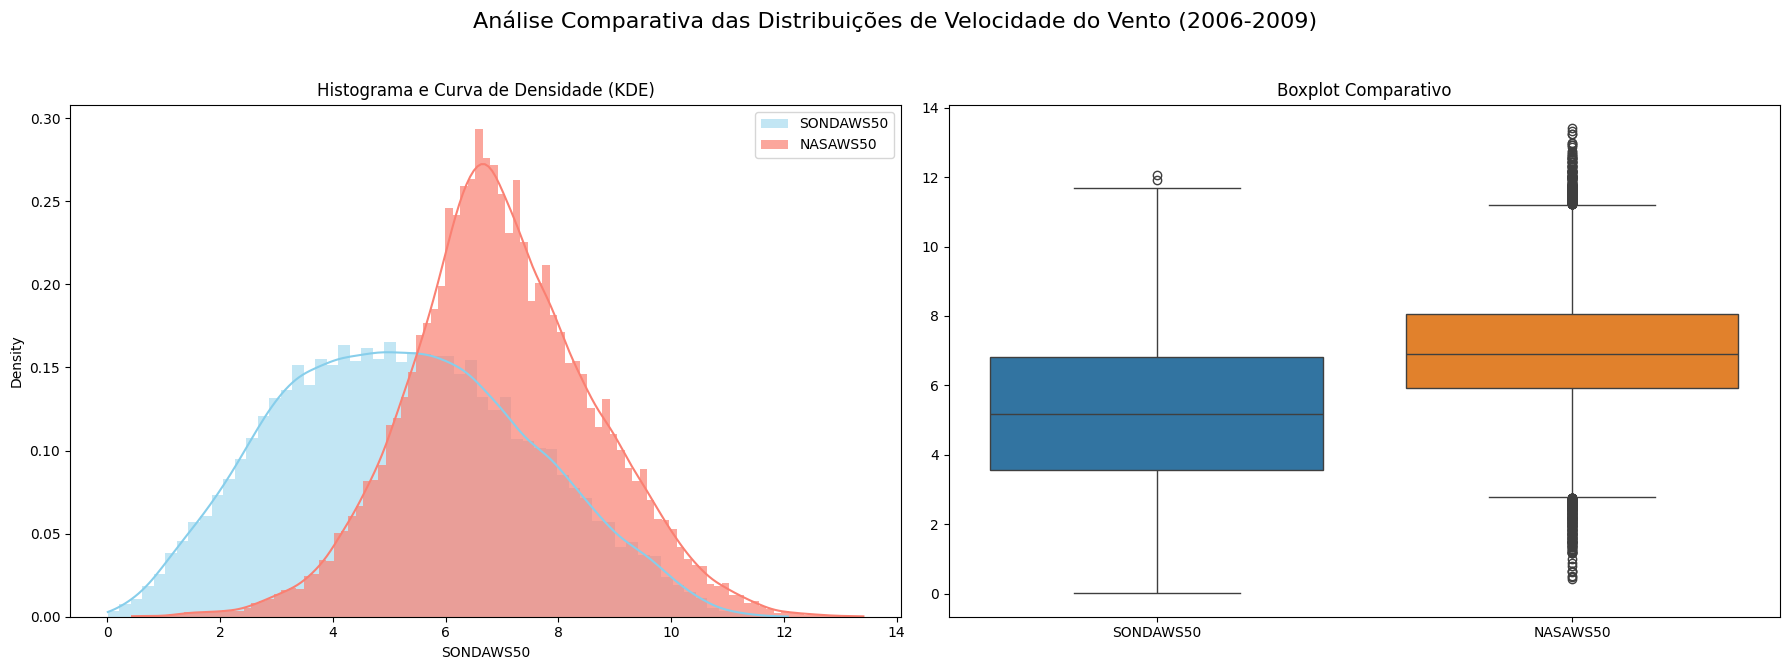

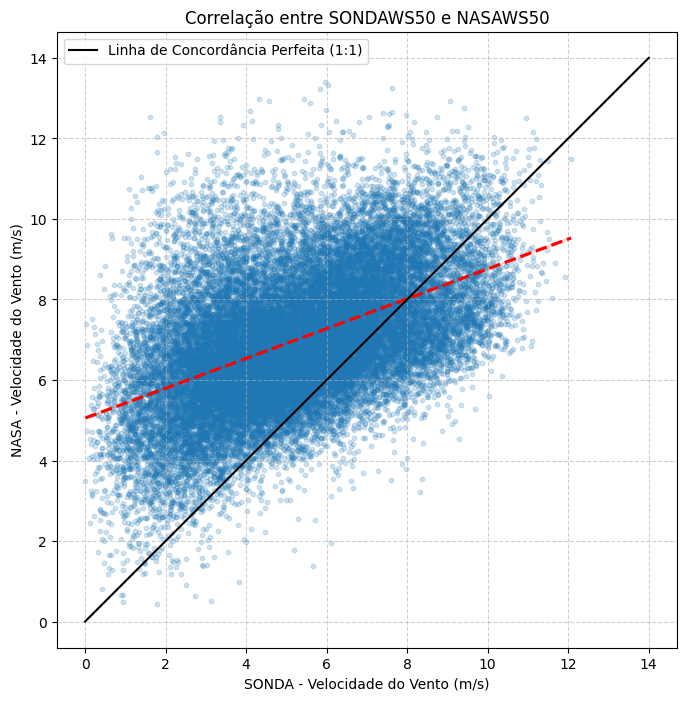

--- FIM DA ANÁLISE COMPLETA ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import warnings

warnings.filterwarnings('ignore')

# --- Etapa Consolidada: Análise Estatística Completa e Visualização ---
print('=' * 80)
print("--- Iniciando a Análise Estatística Completa e Comparativa ---")
print('=' * 80)

# Caminho para o arquivo integrado final
path_integrado = '/content/drive/MyDrive/projeto_wscariri/df_integrado_2006_2009.csv'

try:
    # Carregar o dataset integrado
    print(f"Carregando o arquivo: '{os.path.basename(path_integrado)}'...")
    df_integrado = pd.read_csv(path_integrado, sep=";", index_col=0, parse_dates=True)
    df_integrado.index.name = 'datetm'
    print("Dataset integrado carregado com sucesso.")

    # Criar DataFrame para a análise comparativa (sem NAs)
    df_comp = df_integrado.dropna()

    # =================================================================
    # 1. CÁLCULO DE TODAS AS MÉTRICAS ESTATÍSTICAS
    # =================================================================

    # Descritivas básicas
    desc_sonda = df_comp['SONDAWS50'].describe()
    desc_nasa = df_comp['NASAWS50'].describe()

    # Métricas de forma (assimetria e curtose)
    skew_sonda = df_comp['SONDAWS50'].skew()
    kurt_sonda = df_comp['SONDAWS50'].kurtosis()
    skew_nasa = df_comp['NASAWS50'].skew()
    kurt_nasa = df_comp['NASAWS50'].kurtosis()

    # Métricas de erro e correlação
    bias = (df_comp['NASAWS50'] - df_comp['SONDAWS50']).mean()
    mae = (df_comp['NASAWS50'] - df_comp['SONDAWS50']).abs().mean()
    rmse = np.sqrt(((df_comp['NASAWS50'] - df_comp['SONDAWS50']) ** 2).mean())
    correlation = df_comp['SONDAWS50'].corr(df_comp['NASAWS50'])
    r_squared = correlation**2

    # Ajuste da Distribuição de Weibull
    k_sonda, loc_sonda, scale_sonda = stats.weibull_min.fit(df_comp['SONDAWS50'], floc=0)
    k_nasa, loc_nasa, scale_nasa = stats.weibull_min.fit(df_comp['NASAWS50'], floc=0)

    # =================================================================
    # 2. APRESENTAÇÃO DAS TABELAS E MÉTRICAS
    # =================================================================

    print("\n--- TABELAS DE ANÁLISE ESTATÍSTICA ---")

    # Tabela 1: Estatísticas Descritivas Gerais
    tabela_desc = pd.DataFrame({'SONDAWS50': desc_sonda, 'NASAWS50': desc_nasa}).T
    tabela_desc['Valores Nulos'] = [df_integrado['SONDAWS50'].isna().sum(), df_integrado['NASAWS50'].isna().sum()]
    tabela_desc = tabela_desc[['count', 'Valores Nulos', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    tabela_desc.rename(columns={'count': 'Contagem','mean': 'Média','std': 'Desvio Padrão','min': 'Mínimo','25%': 'Q1','50%': 'Mediana','75%': 'Q3','max': 'Máximo'}, inplace=True)
    print("\n----- Estatísticas Descritivas -----")
    display(tabela_desc.round(2))

    # Tabela 2: Forma da Distribuição
    tabela_forma = pd.DataFrame({'Assimetria': [skew_sonda, skew_nasa], 'Curtose': [kurt_sonda, kurt_nasa]}, index=['SONDAWS50', 'NASAWS50'])
    print("\n----- Forma da Distribuição -----")
    display(tabela_forma.round(2))

    # Tabela 3: Parâmetros de Weibull
    tabela_weibull = pd.DataFrame({'Parâmetro de Forma (k)': [k_sonda, k_nasa], 'Parâmetro de Escala (λ)': [scale_sonda, scale_nasa]}, index=['SONDAWS50', 'NASAWS50'])
    print("\n----- Parâmetros da Distribuição de Weibull -----")
    display(tabela_weibull.round(2))

    # Métricas de Relação e Erro
    print("\n----- Relação e Erro -----")
    print(f"  Correlação de Pearson (r): {correlation:.2f}")
    print(f"  Coeficiente de Determinação (R²): {r_squared:.2f}")
    print(f"  BIAS (Erro Médio - NASA-SONDA): {bias:.2f} m/s")
    print(f"  RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f} m/s")

    # =================================================================
    # 3. APRESENTAÇÃO DAS VISUALIZAÇÕES
    # =================================================================

    print("\n--- GRÁFICOS DE ANÁLISE COMPARATIVA ---")

    # Gráfico 1: Histograma e Boxplot
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle('Análise Comparativa das Distribuições de Velocidade do Vento (2006-2009)', fontsize=16)
    sns.histplot(df_comp['SONDAWS50'], color="skyblue", label='SONDAWS50', kde=True, stat="density", linewidth=0, ax=axes[0])
    sns.histplot(df_comp['NASAWS50'], color="salmon", label='NASAWS50', kde=True, stat="density", linewidth=0, ax=axes[0], alpha=0.7)
    axes[0].set_title('Histograma e Curva de Densidade (KDE)')
    axes[0].legend()
    sns.boxplot(data=df_comp[['SONDAWS50', 'NASAWS50']], ax=axes[1])
    axes[1].set_title('Boxplot Comparativo')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Gráfico 2: Gráfico de Dispersão (Correlação)
    plt.figure(figsize=(8, 8))
    sns.regplot(x='SONDAWS50', y='NASAWS50', data=df_comp, scatter_kws={'alpha':0.2, 's':10}, line_kws={'color':'red', 'linestyle':'--'})
    plt.title('Correlação entre SONDAWS50 e NASAWS50')
    plt.xlabel('SONDA - Velocidade do Vento (m/s)')
    plt.ylabel('NASA - Velocidade do Vento (m/s)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axis('equal')
    plt.plot([0, 14], [0, 14], 'k-', label='Linha de Concordância Perfeita (1:1)')
    plt.legend()
    plt.show()

except FileNotFoundError:
    print(f"\nERRO FATAL: O arquivo integrado '{path_integrado}' não foi encontrado.")
except Exception as e:
    print(f"\nERRO INESPERADO: {e}")

print('=' * 80)
print("--- FIM DA ANÁLISE COMPLETA ---")
print('=' * 80)

---
### **Gráfico de Séries Temporais das Médias Mensais**
---

--- Gerando o Gráfico de Médias Mensais (SONDA vs. NASA) ---
Carregando o arquivo: 'df_integrado_2006_2009.csv'...
Dataset integrado carregado com sucesso.

Médias mensais calculadas. Preparando para plotar o gráfico...


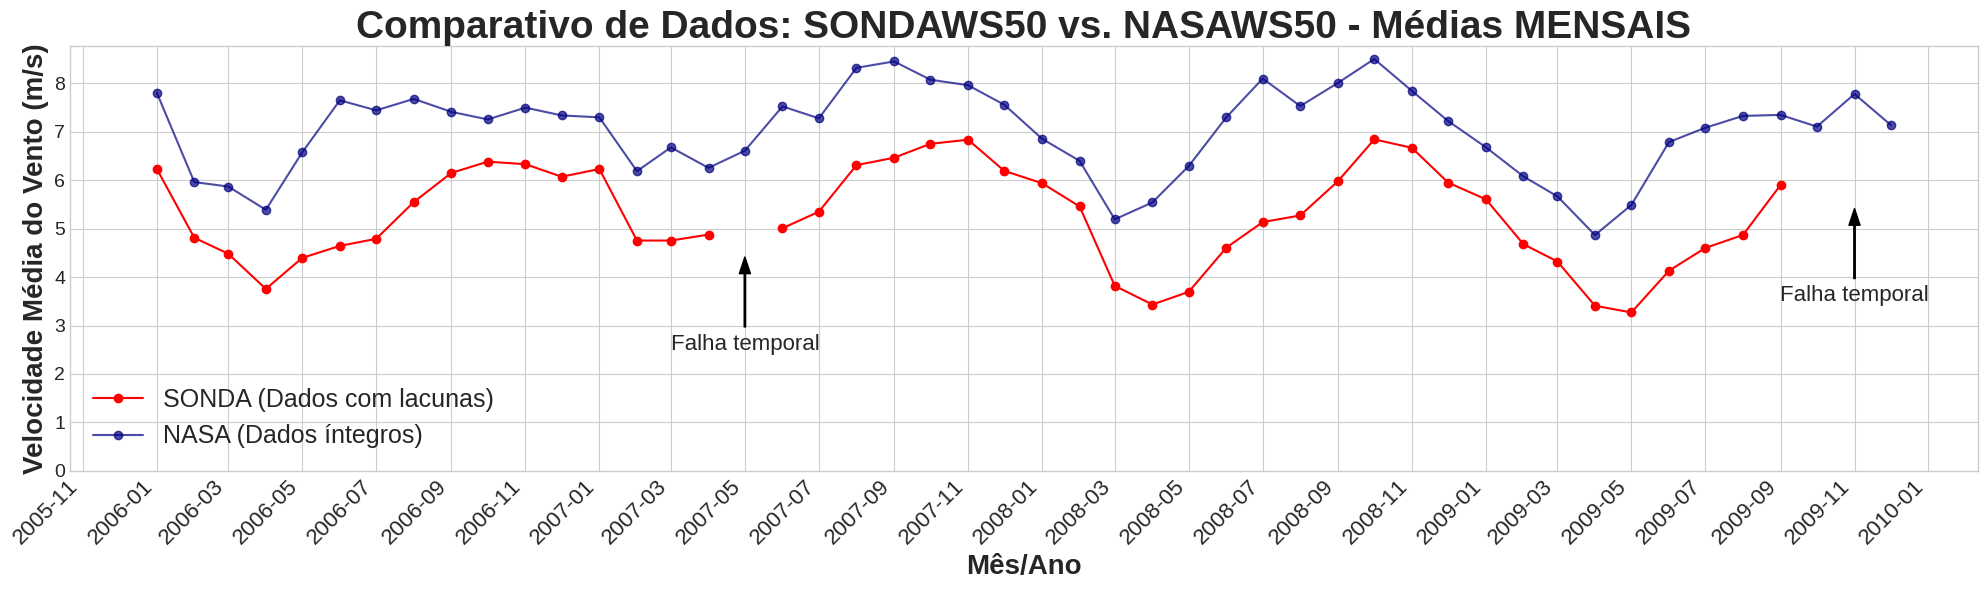

--- FIM DA GERAÇÃO DO GRÁFICO ---


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os

# --- Etapa: Gráfico de Séries Temporais Mensais ---
print('=' * 80)
print("--- Gerando o Gráfico de Médias Mensais (SONDA vs. NASA) ---")
print('=' * 80)

# Caminho para o arquivo integrado final
path_integrado = '/content/drive/MyDrive/projeto_wscariri/df_integrado_2006_2009.csv'

try:
    # Carregar o dataset integrado
    print(f"Carregando o arquivo: '{os.path.basename(path_integrado)}'...")
    df_integrado = pd.read_csv(path_integrado, sep=";", index_col=0, parse_dates=True)
    df_integrado.index.name = 'datetm'
    print("Dataset integrado carregado com sucesso.")

    # 1. Reamostrar os dados para a média mensal
    # 'MS' significa 'Month Start', ou seja, agrupar por início do mês.
    df_mensal = df_integrado.resample('MS').mean()

    print("\nMédias mensais calculadas. Preparando para plotar o gráfico...")

    # 2. Gerar o gráfico de linhas
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(20, 6))

    # Plotar os dados da SONDA
    ax.plot(df_mensal.index, df_mensal['SONDAWS50'], marker='o', linestyle='-', color='red', label='SONDA (Dados com lacunas)')

    # Plotar os dados da NASA
    ax.plot(df_mensal.index, df_mensal['NASAWS50'], marker='o', linestyle='-', color='navy', alpha=0.7, label='NASA (Dados íntegros)')

    # --- Anotações para as falhas temporais (igual ao seu artigo) ---
    # Anotação para Maio de 2007
    ax.annotate('Falha temporal',
                xy=(pd.to_datetime('2007-05-01'), 4.5),
                xytext=(pd.to_datetime('2007-05-01'), 2.5),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                ha='center', fontsize=16)

    # Anotação para o final de 2009
    ax.annotate('Falha temporal',
                xy=(pd.to_datetime('2009-11-01'), 5.5),
                xytext=(pd.to_datetime('2009-11-01'), 3.5),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                ha='center', fontsize=16)


    # --- Formatação do Gráfico ---
    ax.set_title('Comparativo de Dados: SONDAWS50 vs. NASAWS50 - Médias MENSAIS', fontsize=28, weight='bold')
    ax.set_ylabel('Velocidade Média do Vento (m/s)', fontsize=20, weight='bold')
    ax.set_xlabel('Mês/Ano', fontsize=20, weight='bold')
    ax.legend(fontsize=18)

    # Formatar o eixo X para mostrar o ano e o mês de forma legível
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # Marcas a cada 3 meses
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45, ha='right', fontsize=16)
    plt.yticks(fontsize=14)

    # Ajustar limites do eixo y se necessário
    ax.set_ylim(bottom=0)

    plt.tight_layout()
    plt.show()


except FileNotFoundError:
    print(f"\nERRO FATAL: O arquivo integrado '{path_integrado}' não foi encontrado.")
except Exception as e:
    print(f"\nERRO INESPERADO: {e}")

print('=' * 80)
print("--- FIM DA GERAÇÃO DO GRÁFICO ---")
print('=' * 80)

---
### **Aplicando o modelo Holt-Winters**
---

--- Iniciando a Imputação de Maio/2007 com Holt-Winters (Horário) ---
Dataset integrado carregado com sucesso.

Período de treino definido: 2006-01-01 00:00:00 a 2007-04-30 23:00:00
Tamanho do conjunto de treino: 11640 horas

Treinando o modelo Holt-Winters...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Modelo treinado com sucesso.

Realizando a previsão para as 744 horas de Maio de 2007...
Previsão concluída.

Imputando os valores previstos no DataFrame...
Imputação concluída.

--- Análise de Correlação ---
Correlação de Pearson Original (Jan/06 - Abr/07): 0.4469
Correlação de Pearson Após Imputação (Jan/06 - Mai/07): 0.3993

Visualizando o resultado da imputação...


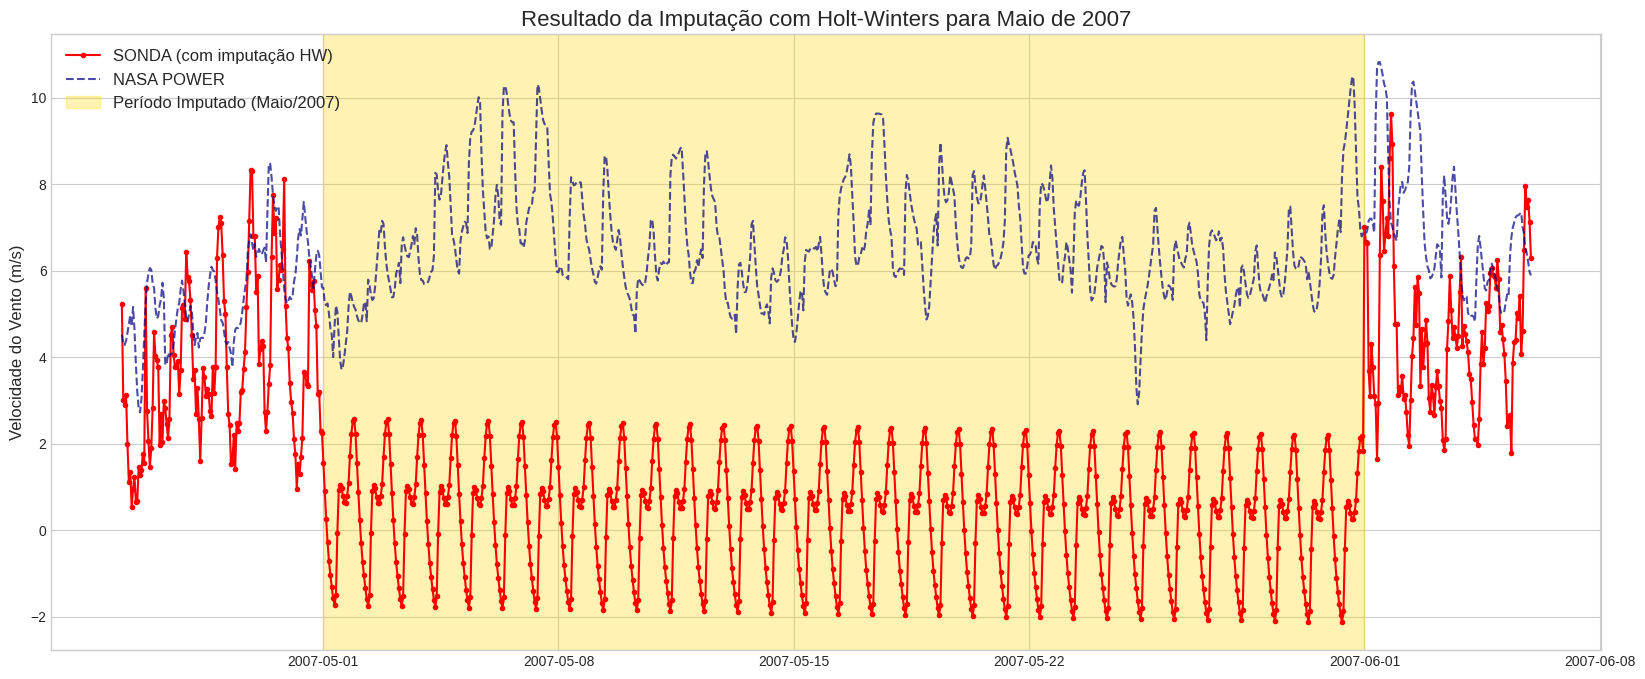

--- FIM DO PROCESSO ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import os

# --- Etapa: Imputação com Holt-Winters e Análise de Correlação ---
print('=' * 80)
print("--- Iniciando a Imputação de Maio/2007 com Holt-Winters (Horário) ---")
print('=' * 80)

# Caminho para o arquivo integrado final
path_integrado = '/content/drive/MyDrive/projeto_wscariri/df_integrado_2006_2009.csv'

try:
    # Carregar o dataset integrado
    df_integrado = pd.read_csv(path_integrado, sep=";", index_col=0, parse_dates=True)
    df_integrado.index.name = 'datetm'
    print("Dataset integrado carregado com sucesso.")

    # --- 1. Preparação dos Dados ---
    # Definir o período de treino (dados antes da lacuna de Maio/2007)
    df_treino = df_integrado.loc['2006-01-01':'2007-04-30']['SONDAWS50'].dropna()
    print(f"\nPeríodo de treino definido: {df_treino.index.min()} a {df_treino.index.max()}")
    print(f"Tamanho do conjunto de treino: {len(df_treino)} horas")

    # --- 2. Treinamento do Modelo Holt-Winters ---
    print("\nTreinando o modelo Holt-Winters...")
    # Usamos um modelo aditivo para tendência e sazonalidade.
    # seasonal_periods=24 porque os dados são horários e a principal sazonalidade é diária.
    modelo_hw = ExponentialSmoothing(
        df_treino,
        trend='add',
        seasonal='add',
        seasonal_periods=24
    ).fit()
    print("Modelo treinado com sucesso.")

    # --- 3. Previsão para Maio de 2007 ---
    # Maio tem 31 dias = 31 * 24 = 744 horas
    print("\nRealizando a previsão para as 744 horas de Maio de 2007...")
    previsao_maio_2007 = modelo_hw.forecast(744)
    print("Previsão concluída.")

    # --- 4. Imputação dos Dados ---
    print("\nImputando os valores previstos no DataFrame...")
    df_imputado = df_integrado.copy()
    # Atribuir os valores previstos ao intervalo de Maio de 2007 na coluna SONDAWS50
    df_imputado.loc['2007-05-01':'2007-05-31', 'SONDAWS50'] = previsao_maio_2007.values
    print("Imputação concluída.")

    # --- 5. Análise de Correlação (Antes e Depois) ---
    print("\n--- Análise de Correlação ---")

    # Correlação original (considerando apenas dados existentes até Abr/2007)
    corr_original = df_integrado.loc['2006-01-01':'2007-04-30'].corr().loc['SONDAWS50', 'NASAWS50']
    print(f"Correlação de Pearson Original (Jan/06 - Abr/07): {corr_original:.4f}")

    # Correlação após a imputação (considerando o período até Mai/2007)
    corr_imputada = df_imputado.loc['2006-01-01':'2007-05-31'].corr().loc['SONDAWS50', 'NASAWS50']
    print(f"Correlação de Pearson Após Imputação (Jan/06 - Mai/07): {corr_imputada:.4f}")

    # --- 6. Visualização do Resultado ---
    print("\nVisualizando o resultado da imputação...")
    fig, ax = plt.subplots(figsize=(20, 8))

    # Plotar um período antes, durante e depois da imputação
    plot_period = df_imputado.loc['2007-04-25':'2007-06-05']

    ax.plot(plot_period.index, plot_period['SONDAWS50'], label='SONDA (com imputação HW)', color='red', marker='.', linestyle='-')
    ax.plot(plot_period.index, plot_period['NASAWS50'], label='NASA POWER', color='navy', alpha=0.7, linestyle='--')

    # Destacar a área imputada
    ax.axvspan(pd.to_datetime('2007-05-01'), pd.to_datetime('2007-06-01'), color='gold', alpha=0.3, label='Período Imputado (Maio/2007)')

    ax.set_title('Resultado da Imputação com Holt-Winters para Maio de 2007', fontsize=16)
    ax.set_ylabel('Velocidade do Vento (m/s)', fontsize=12)
    ax.legend(fontsize=12)
    plt.show()

except Exception as e:
    print(f"\nERRO INESPERADO: {e}")

print('=' * 80)
print("--- FIM DO PROCESSO ---")
print('=' * 80)

---
### **Aplicando o Modelo SARIMAX**
---

--- Iniciando a Imputação de Maio/2007 com SARIMAX (Horário) ---
Dataset integrado carregado com sucesso.

Período de treino definido com 11640 horas de dados.

Treinando o modelo SARIMAX... (Isso pode levar alguns minutos)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Modelo treinado com sucesso.

Realizando a previsão para as 744 horas de Maio de 2007...
Previsão concluída.

Imputando os valores previstos no DataFrame...
Imputação concluída.

--- Análise e Visualização do Resultado ---
Correlação de Pearson Após Imputação SARIMAX (Jan/06 - Mai/07): 0.4444


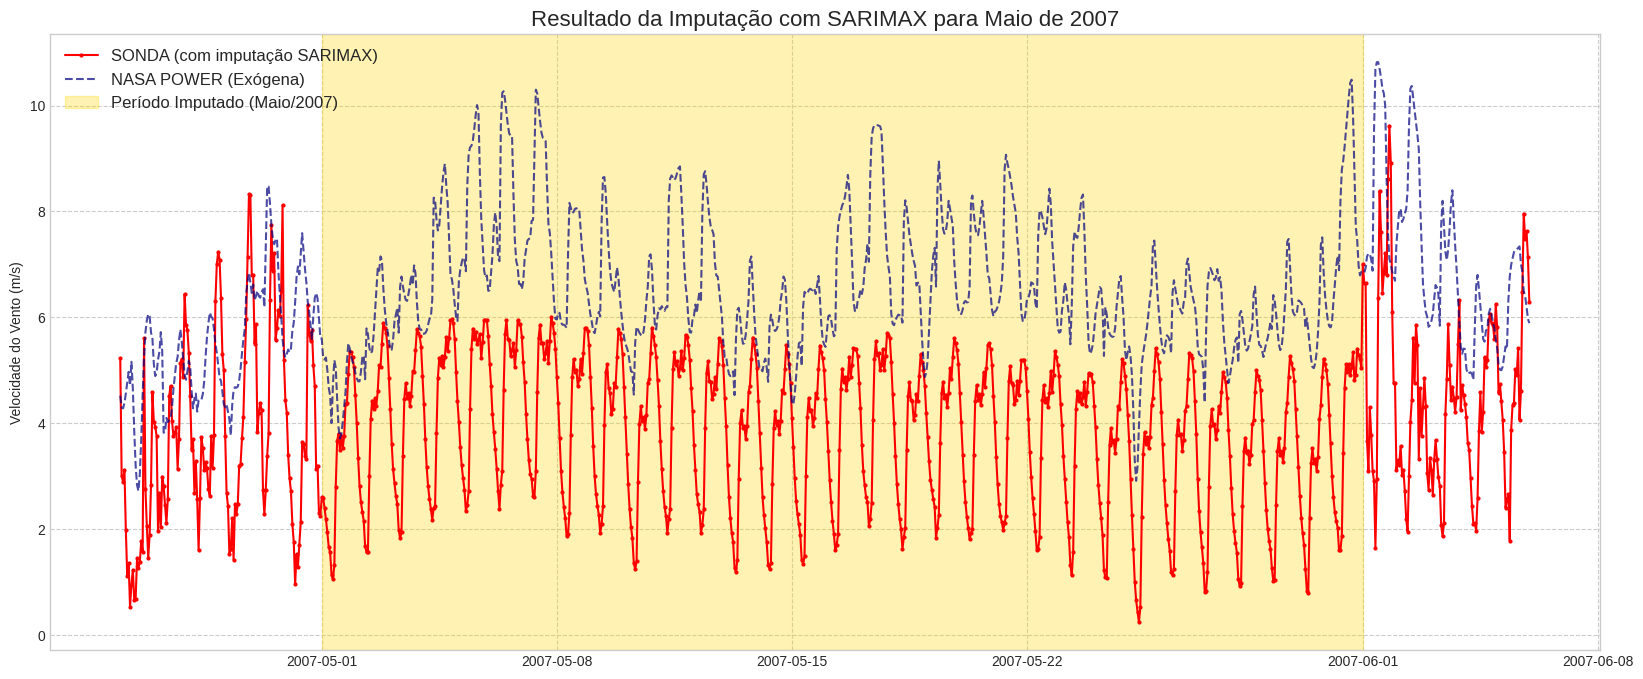

--- FIM DO PROCESSO ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
from IPython.display import display

# --- Etapa: Imputação com SARIMAX e Variável Exógena ---
print('=' * 80)
print("--- Iniciando a Imputação de Maio/2007 com SARIMAX (Horário) ---")
print('=' * 80)

# Caminho para o arquivo integrado final
path_integrado = '/content/drive/MyDrive/projeto_wscariri/df_integrado_2006_2009.csv'

try:
    # Carregar o dataset integrado
    df_integrado = pd.read_csv(path_integrado, sep=";", index_col=0, parse_dates=True)
    df_integrado.index.name = 'datetm'
    print("Dataset integrado carregado com sucesso.")

    # --- 1. Preparação dos Dados ---
    # Período de treino: Jan/2006 a Abr/2007
    train_end = '2007-04-30 23:00:00'
    df_treino = df_integrado.loc[:train_end].dropna() # .dropna() para garantir que não há NAs no treino

    # Período de imputação
    predict_start = '2007-05-01 00:00:00'
    predict_end = '2007-05-31 23:00:00'

    # Definir variáveis endógenas (alvo) e exógenas (preditora)
    endog_treino = df_treino['SONDAWS50']
    exog_treino = df_treino['NASAWS50']
    exog_previsao = df_integrado.loc[predict_start:predict_end]['NASAWS50']

    print(f"\nPeríodo de treino definido com {len(endog_treino)} horas de dados.")

    # --- 2. Treinamento do Modelo SARIMAX ---
    print("\nTreinando o modelo SARIMAX... (Isso pode levar alguns minutos)")
    # Ordem (p,d,q): Parâmetros não-sazonais (AR, Diferenciação, MA)
    # Ordem Sazonal (P,D,Q,s): Parâmetros sazonais com período s=24 (diário)
    # Estes são parâmetros iniciais comuns, um ajuste fino (Grid Search) poderia otimizá-los.
    modelo_sarimax = sm.tsa.SARIMAX(
        endog=endog_treino,
        exog=exog_treino,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 24)
    ).fit(disp=False) # disp=False para suprimir a saída de convergência

    print("Modelo treinado com sucesso.")
    # print(modelo_sarimax.summary()) # Descomente para ver detalhes do modelo treinado

    # --- 3. Previsão para Maio de 2007 ---
    print(f"\nRealizando a previsão para as {len(exog_previsao)} horas de Maio de 2007...")
    previsao_maio_2007_sarimax = modelo_sarimax.predict(
        start=predict_start,
        end=predict_end,
        exog=exog_previsao
    )
    print("Previsão concluída.")

    # --- 4. Imputação dos Dados ---
    print("\nImputando os valores previstos no DataFrame...")
    df_imputado_sarimax = df_integrado.copy()
    df_imputado_sarimax.loc[predict_start:predict_end, 'SONDAWS50'] = previsao_maio_2007_sarimax.values
    print("Imputação concluída.")

    # --- 5. Análise e Visualização ---
    print("\n--- Análise e Visualização do Resultado ---")

    # Calcular a correlação após a imputação SARIMAX
    corr_imputada_sarimax = df_imputado_sarimax.loc['2006-01-01':'2007-05-31'].corr().loc['SONDAWS50', 'NASAWS50']
    print(f"Correlação de Pearson Após Imputação SARIMAX (Jan/06 - Mai/07): {corr_imputada_sarimax:.4f}")

    # Plotar o resultado
    fig, ax = plt.subplots(figsize=(20, 8))
    plot_period = df_imputado_sarimax.loc['2007-04-25':'2007-06-05']

    ax.plot(plot_period.index, plot_period['SONDAWS50'], label='SONDA (com imputação SARIMAX)', color='red', marker='.', markersize=4, linestyle='-')
    ax.plot(plot_period.index, plot_period['NASAWS50'], label='NASA POWER (Exógena)', color='navy', alpha=0.7, linestyle='--')
    ax.axvspan(pd.to_datetime(predict_start), pd.to_datetime(predict_end) + pd.Timedelta(hours=1), color='gold', alpha=0.3, label='Período Imputado (Maio/2007)')

    ax.set_title('Resultado da Imputação com SARIMAX para Maio de 2007', fontsize=16)
    ax.set_ylabel('Velocidade do Vento (m/s)')
    ax.legend(fontsize=12)
    plt.grid(True, linestyle='--')
    plt.show()

except Exception as e:
    print(f"\nERRO INESPERADO: {e}")

print('=' * 80)
print("--- FIM DO PROCESSO ---")
print('=' * 80)

---
### **Aplicando o Modelo Random Forest**
---

--- Iniciando a Imputação de Maio/2007 com Random Forest (Horário) ---
Dataset integrado carregado com sucesso.

Conjunto de treino definido com 31867 observações.
Total de 3197 pontos a serem imputados.

Treinando o modelo Random Forest...
Modelo treinado com sucesso.

Realizando a previsão dos valores faltantes...
Previsão concluída.

Imputando os valores e analisando o resultado...
Imputação concluída.

Correlação de Pearson no Período Imputado (Maio/2007): 0.9444

Visualizando o resultado da imputação para Maio de 2007...


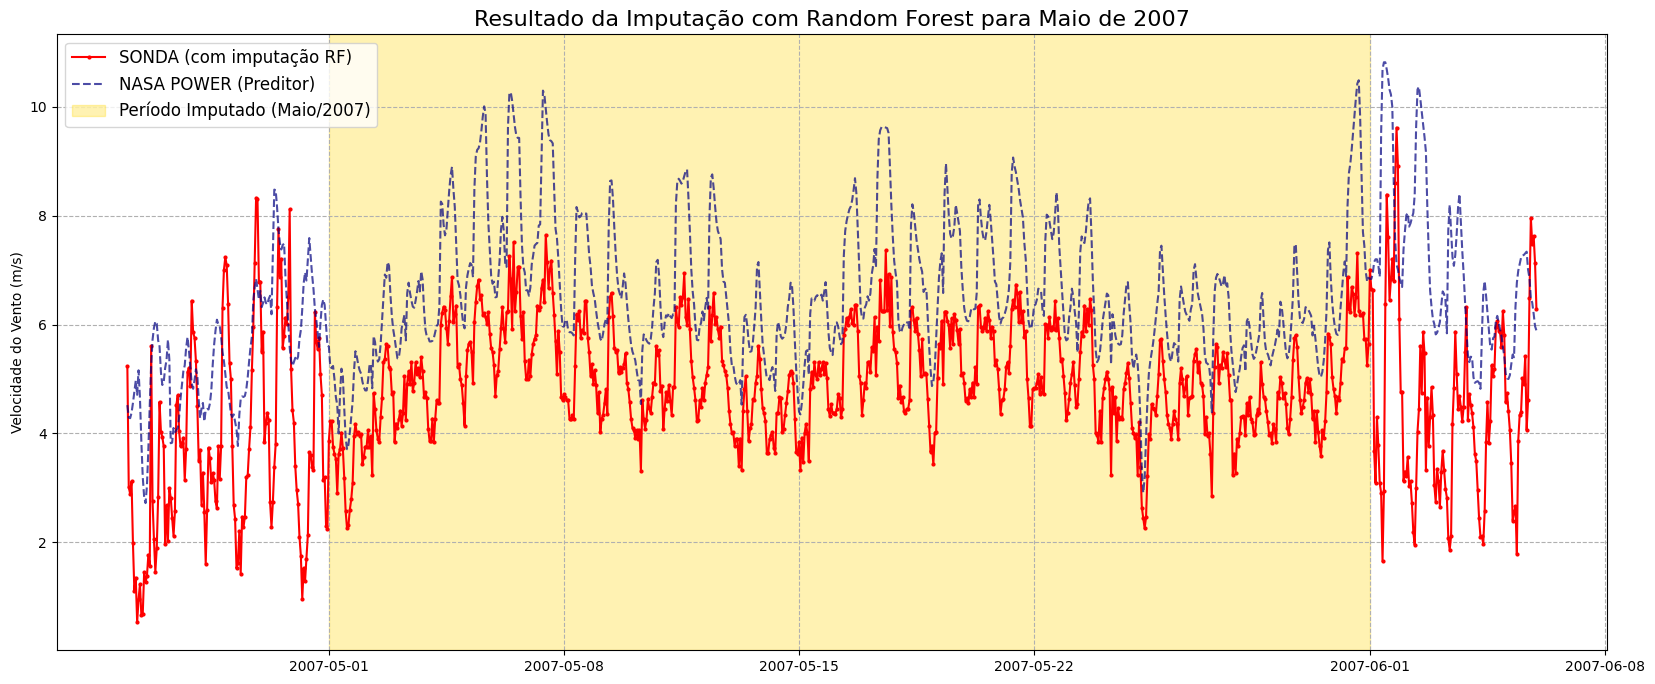

--- FIM DO PROCESSO ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import os
from IPython.display import display

# --- Etapa: Imputação com Random Forest ---
print('=' * 80)
print("--- Iniciando a Imputação de Maio/2007 com Random Forest (Horário) ---")
print('=' * 80)

# Caminho para o arquivo integrado final
path_integrado = '/content/drive/MyDrive/projeto_wscariri/df_integrado_2006_2009.csv'

try:
    # Carregar o dataset integrado
    df_integrado = pd.read_csv(path_integrado, sep=";", index_col=0, parse_dates=True)
    df_integrado.index.name = 'datetm'
    print("Dataset integrado carregado com sucesso.")

    # --- 1. Preparação dos Conjuntos de Treino e Previsão ---
    # O conjunto de treino são os dados onde ambas as colunas existem (sem NAs)
    df_treino_rf = df_integrado.dropna()

    # O conjunto para o qual queremos prever são as horas em que SONDA é nulo, mas NASA não é.
    df_previsao_rf = df_integrado[df_integrado['SONDAWS50'].isnull()]

    # Separar em X (features/preditores) e y (alvo)
    X_treino = df_treino_rf[['NASAWS50']]
    y_treino = df_treino_rf['SONDAWS50']

    # O X para a previsão são os dados da NASA nos períodos de lacuna
    X_previsao = df_previsao_rf[['NASAWS50']]

    print(f"\nConjunto de treino definido com {len(X_treino)} observações.")
    print(f"Total de {len(X_previsao)} pontos a serem imputados.")

    # --- 2. Treinamento do Modelo Random Forest ---
    print("\nTreinando o modelo Random Forest...")
    # n_estimators: número de árvores na floresta
    # random_state: garante que o resultado seja reprodutível
    # n_jobs=-1: usa todos os processadores disponíveis para acelerar o treino
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_treino, y_treino)
    print("Modelo treinado com sucesso.")

    # --- 3. Previsão dos Valores Faltantes ---
    print("\nRealizando a previsão dos valores faltantes...")
    valores_imputados_rf = rf_model.predict(X_previsao)
    print("Previsão concluída.")

    # --- 4. Imputação e Análise ---
    print("\nImputando os valores e analisando o resultado...")
    df_imputado_rf = df_integrado.copy()
    # Preencher os valores nulos na coluna SONDAWS50 com as previsões
    df_imputado_rf.loc[df_imputado_rf['SONDAWS50'].isnull(), 'SONDAWS50'] = valores_imputados_rf
    print("Imputação concluída.")

    # Calcular a correlação para o período de Maio/2007
    corr_imputada_rf = df_imputado_rf.loc['2007-05-01':'2007-05-31'].corr().loc['SONDAWS50', 'NASAWS50']
    print(f"\nCorrelação de Pearson no Período Imputado (Maio/2007): {corr_imputada_rf:.4f}")

    # --- 5. Visualização do Resultado ---
    print("\nVisualizando o resultado da imputação para Maio de 2007...")
    fig, ax = plt.subplots(figsize=(20, 8))

    plot_period = df_imputado_rf.loc['2007-04-25':'2007-06-05']

    ax.plot(plot_period.index, plot_period['SONDAWS50'], label='SONDA (com imputação RF)', color='red', marker='.', markersize=4, linestyle='-')
    ax.plot(plot_period.index, plot_period['NASAWS50'], label='NASA POWER (Preditor)', color='navy', alpha=0.7, linestyle='--')
    ax.axvspan(pd.to_datetime('2007-05-01'), pd.to_datetime('2007-06-01'), color='gold', alpha=0.3, label='Período Imputado (Maio/2007)')

    ax.set_title('Resultado da Imputação com Random Forest para Maio de 2007', fontsize=16)
    ax.set_ylabel('Velocidade do Vento (m/s)')
    ax.legend(fontsize=12)
    plt.grid(True, linestyle='--')
    plt.show()

except Exception as e:
    print(f"\nERRO INESPERADO: {e}")

print('=' * 80)
print("--- FIM DO PROCESSO ---")
print('=' * 80)

---
### **Imputação de Dados a Falha Temporal Final**
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display

# --- Etapa: Imputação Final de Todas as Lacunas com Random Forest ---
print('=' * 80)
print("--- Gerando o dataset final WSCariri-DE ---")
print('=' * 80)

# Supondo que 'df_integrado' e 'rf_model' já estão na memória das etapas anteriores.
# Se não estiverem, descomente as linhas abaixo para recarregá-los/retreiná-los.
# path_integrado = '/content/drive/MyDrive/projeto_wscariri/df_integrado_2006_2009.csv'
# df_integrado = pd.read_csv(path_integrado, sep=";", index_col=0, parse_dates=True)
# # (O código de treinamento do RF da etapa anterior precisaria ser executado aqui se 'rf_model' não existir)


try:
    # 1. Identificar TODAS as lacunas restantes no dataset
    print(f"Identificando todas as lacunas restantes em 'SONDAWS50'...")
    lacunas_a_preencher = df_integrado[df_integrado['SONDAWS50'].isnull()]

    if not lacunas_a_preencher.empty:
        # Extrair a variável preditora (NASA) para esses pontos
        X_para_imputar = lacunas_a_preencher[['NASAWS50']]
        print(f"  - Total de {len(X_para_imputar)} pontos a serem imputados.")

        # 2. Usar o modelo JÁ TREINADO para prever os valores
        print("\nUtilizando o modelo Random Forest treinado para prever os valores...")
        valores_imputados_finais = rf_model.predict(X_para_imputar)

        # Arredondar os valores previstos para duas casas decimais
        valores_imputados_finais = np.round(valores_imputados_finais, 2)
        print("  - Previsão concluída.")

        # 3. Criar o DataFrame final e preencher as lacunas
        print("\nCriando o dataset WSCariri-DE e preenchendo as lacunas...")
        WSCariri_DE = df_integrado.copy()
        WSCariri_DE.loc[WSCariri_DE['SONDAWS50'].isnull(), 'SONDAWS50'] = valores_imputados_finais
        print("  - Imputação finalizada com sucesso.")

    else:
        print("\nNão foram encontradas lacunas no dataset. O DataFrame já está completo.")
        WSCariri_DE = df_integrado.copy()


    # 4. Verificação Final do Dataset WSCariri-DE
    print("\n--- VERIFICAÇÃO FINAL DO DATASET WSCariri-DE ---")
    print(f"Dimensões do dataset final: {WSCariri_DE.shape}")
    print("\nVerificação de dados nulos:")
    # A contagem de nulos para SONDAWS50 agora deve ser 0
    print(WSCariri_DE.isna().sum())

    print("\nVisualização das primeiras linhas do dataset final:")
    display(WSCariri_DE.head())

    print("\nVisualização do período de Outubro a Dezembro de 2009 (agora preenchido):")
    display(WSCariri_DE.loc['2009-10-01':'2009-10-01 05:00:00'])

    # 5. Salvar o Dataset Final
    path_wscariri_de = '/content/drive/MyDrive/projeto_wscariri/WSCariri-DE.csv'
    print(f"\nSalvando o dataset final 'WSCariri-DE.csv' em:\n'{path_wscariri_de}'")
    WSCariri_DE.to_csv(path_wscariri_de, sep=";")
    print("Dataset salvo com sucesso!")


except NameError as e:
    print(f"\nERRO: A variável '{e.name}' não foi encontrada. Certifique-se de que as etapas anteriores foram executadas.")
except Exception as e:
    print(f"\nERRO INESPERADO: {e}")

print('=' * 80)
print("--- PROCESSO DE CRIAÇÃO DO WSCariri-DE CONCLUÍDO ---")
print('=' * 80)

--- Gerando o dataset final WSCariri-DE ---
Identificando todas as lacunas restantes em 'SONDAWS50'...
  - Total de 3197 pontos a serem imputados.

Utilizando o modelo Random Forest treinado para prever os valores...
  - Previsão concluída.

Criando o dataset WSCariri-DE e preenchendo as lacunas...
  - Imputação finalizada com sucesso.

--- VERIFICAÇÃO FINAL DO DATASET WSCariri-DE ---
Dimensões do dataset final: (35064, 2)

Verificação de dados nulos:
SONDAWS50    0
NASAWS50     0
dtype: int64

Visualização das primeiras linhas do dataset final:


,SONDAWS50,NASAWS50
datetm,,
2006-01-01 00:00:00,7.87,6.99
2006-01-01 01:00:00,7.06,6.82
2006-01-01 02:00:00,5.93,6.67
2006-01-01 03:00:00,4.00,6.63
2006-01-01 04:00:00,4.42,7.06



Visualização do período de Outubro a Dezembro de 2009 (agora preenchido):


,SONDAWS50,NASAWS50
datetm,,
2009-10-01 00:00:00,5.30,6.78
2009-10-01 01:00:00,5.00,6.54
2009-10-01 02:00:00,4.78,6.33
2009-10-01 03:00:00,4.85,6.19
2009-10-01 04:00:00,4.82,6.10
2009-10-01 05:00:00,4.45,6.04



Salvando o dataset final 'WSCariri-DE.csv' em:
'/content/drive/MyDrive/projeto_wscariri/WSCariri-DE.csv'
Dataset salvo com sucesso!
--- PROCESSO DE CRIAÇÃO DO WSCariri-DE CONCLUÍDO ---


---
#### **Análise estatística para o dataset final**
---

--- Iniciando a Análise Estatística do Dataset Final WSCariri-DE ---
Carregando o arquivo: 'WSCariri-DE.csv'...
Dataset WSCariri-DE carregado com sucesso.

--- TABELAS DE ANÁLISE ESTATÍSTICA FINAL ---

----- Estatísticas Descritivas -----


,Contagem,Valores Nulos,Média,Desvio Padrão,Mínimo,Q1,Mediana,Q3,Máximo
SONDAWS50,35064.0,0,5.26,2.11,0.01,3.72,5.22,6.69,12.07
NASAWS50,35064.0,0,7.01,1.63,0.44,5.97,6.91,8.06,13.41



----- Forma da Distribuição -----


,Assimetria,Curtose
SONDAWS50,0.14,-0.45
NASAWS50,0.09,0.24



----- Parâmetros da Distribuição de Weibull -----


,Parâmetro de Forma (k),Parâmetro de Escala (λ)
SONDAWS50,2.69,5.91
NASAWS50,4.66,7.65



----- Relação e Erro (Série Completa) -----
  Correlação de Pearson (r): 0.50
  Coeficiente de Determinação (R²): 0.25
  BIAS (Erro Médio - NASA-SONDA): 1.75 m/s
  RMSE (Raiz do Erro Quadrático Médio): 2.59 m/s

--- GRÁFICOS DE ANÁLISE FINAL ---


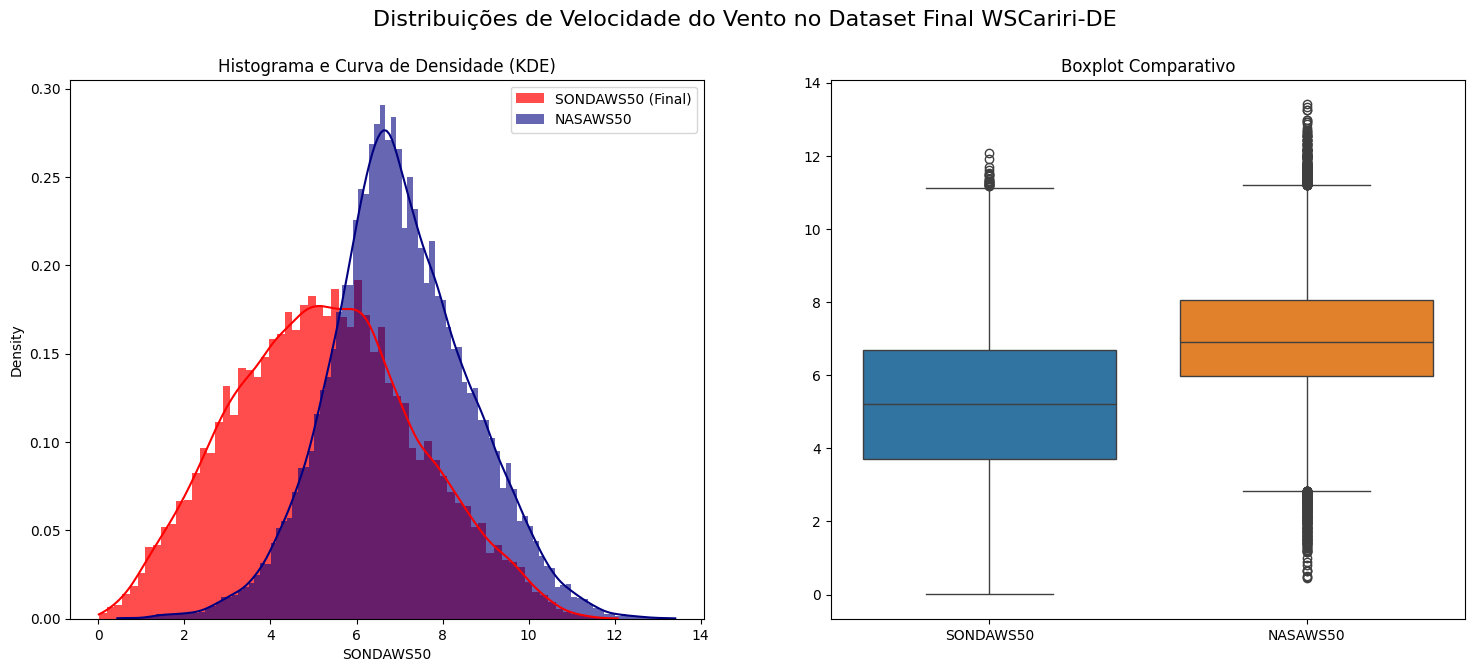

--- FIM DA ANÁLISE FINAL ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
from IPython.display import display

# --- Etapa Final: Análise Estatística do Dataset WSCariri-DE ---
print('=' * 80)
print("--- Iniciando a Análise Estatística do Dataset Final WSCariri-DE ---")
print('=' * 80)

# Caminho para o arquivo final
path_wscariri_de = '/content/drive/MyDrive/projeto_wscariri/WSCariri-DE.csv'

try:
    # Carregar o dataset final
    print(f"Carregando o arquivo: '{os.path.basename(path_wscariri_de)}'...")
    WSCariri_DE = pd.read_csv(path_wscariri_de, sep=";", index_col=0, parse_dates=True)
    WSCariri_DE.index.name = 'datetm'
    print("Dataset WSCariri-DE carregado com sucesso.")

    # =================================================================
    # 1. CÁLCULO DE TODAS AS MÉTRICAS ESTATÍSTICAS
    # =================================================================

    # Descritivas básicas
    desc_sonda_final = WSCariri_DE['SONDAWS50'].describe()
    desc_nasa = WSCariri_DE['NASAWS50'].describe()

    # Métricas de forma
    skew_sonda = WSCariri_DE['SONDAWS50'].skew()
    kurt_sonda = WSCariri_DE['SONDAWS50'].kurtosis()
    skew_nasa = WSCariri_DE['NASAWS50'].skew()
    kurt_nasa = WSCariri_DE['NASAWS50'].kurtosis()

    # Métricas de erro e correlação
    bias = (WSCariri_DE['NASAWS50'] - WSCariri_DE['SONDAWS50']).mean()
    rmse = np.sqrt(((WSCariri_DE['NASAWS50'] - WSCariri_DE['SONDAWS50']) ** 2).mean())
    correlation = WSCariri_DE['SONDAWS50'].corr(WSCariri_DE['NASAWS50'])
    r_squared = correlation**2

    # Ajuste da Distribuição de Weibull
    k_sonda, loc, scale_sonda = stats.weibull_min.fit(WSCariri_DE['SONDAWS50'], floc=0)
    k_nasa, loc, scale_nasa = stats.weibull_min.fit(WSCariri_DE['NASAWS50'], floc=0)

    # =================================================================
    # 2. APRESENTAÇÃO DAS TABELAS E MÉTRICAS
    # =================================================================

    print("\n--- TABELAS DE ANÁLISE ESTATÍSTICA FINAL ---")

    # Tabela 1: Estatísticas Descritivas
    tabela_desc = pd.DataFrame({'SONDAWS50': desc_sonda_final, 'NASAWS50': desc_nasa}).T
    tabela_desc['Valores Nulos'] = WSCariri_DE.isna().sum().values
    tabela_desc = tabela_desc[['count', 'Valores Nulos', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    tabela_desc.rename(columns={'count': 'Contagem','mean': 'Média','std': 'Desvio Padrão','min': 'Mínimo','25%': 'Q1','50%': 'Mediana','75%': 'Q3','max': 'Máximo'}, inplace=True)
    print("\n----- Estatísticas Descritivas -----")
    display(tabela_desc.round(2))

    # Tabela 2: Forma da Distribuição
    tabela_forma = pd.DataFrame({'Assimetria': [skew_sonda, skew_nasa], 'Curtose': [kurt_sonda, kurt_nasa]}, index=['SONDAWS50', 'NASAWS50'])
    print("\n----- Forma da Distribuição -----")
    display(tabela_forma.round(2))

    # Tabela 3: Parâmetros de Weibull
    tabela_weibull = pd.DataFrame({'Parâmetro de Forma (k)': [k_sonda, k_nasa], 'Parâmetro de Escala (λ)': [scale_sonda, scale_nasa]}, index=['SONDAWS50', 'NASAWS50'])
    print("\n----- Parâmetros da Distribuição de Weibull -----")
    display(tabela_weibull.round(2))

    # Métricas de Relação e Erro
    print("\n----- Relação e Erro (Série Completa) -----")
    print(f"  Correlação de Pearson (r): {correlation:.2f}")
    print(f"  Coeficiente de Determinação (R²): {r_squared:.2f}")
    print(f"  BIAS (Erro Médio - NASA-SONDA): {bias:.2f} m/s")
    print(f"  RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f} m/s")

    # =================================================================
    # 3. APRESENTAÇÃO DAS VISUALIZAÇÕES
    # =================================================================

    print("\n--- GRÁFICOS DE ANÁLISE FINAL ---")

    # Gráfico 1: Histograma e Boxplot
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle('Distribuições de Velocidade do Vento no Dataset Final WSCariri-DE', fontsize=16)
    sns.histplot(WSCariri_DE['SONDAWS50'], color="red", label='SONDAWS50 (Final)', kde=True, stat="density", linewidth=0, ax=axes[0], alpha=0.7)
    sns.histplot(WSCariri_DE['NASAWS50'], color="navy", label='NASAWS50', kde=True, stat="density", linewidth=0, ax=axes[0], alpha=0.6)
    axes[0].set_title('Histograma e Curva de Densidade (KDE)')
    axes[0].legend()
    sns.boxplot(data=WSCariri_DE[['SONDAWS50', 'NASAWS50']], ax=axes[1])
    axes[1].set_title('Boxplot Comparativo')
    plt.show()

except FileNotFoundError:
    print(f"\nERRO FATAL: O arquivo '{path_wscariri_de}' não foi encontrado.")
except Exception as e:
    print(f"\nERRO INESPERADO: {e}")

print('=' * 80)
print("--- FIM DA ANÁLISE FINAL ---")
print('=' * 80)

---
#### **Gráfico de Série Temporal para o Dataset Completo**
---

--- Gerando o Gráfico de Médias Mensais do Dataset WSCariri-DE ---
Carregando o arquivo: 'WSCariri-DE.csv'...
Dataset WSCariri-DE carregado com sucesso.

Médias mensais calculadas. Preparando para plotar o gráfico...


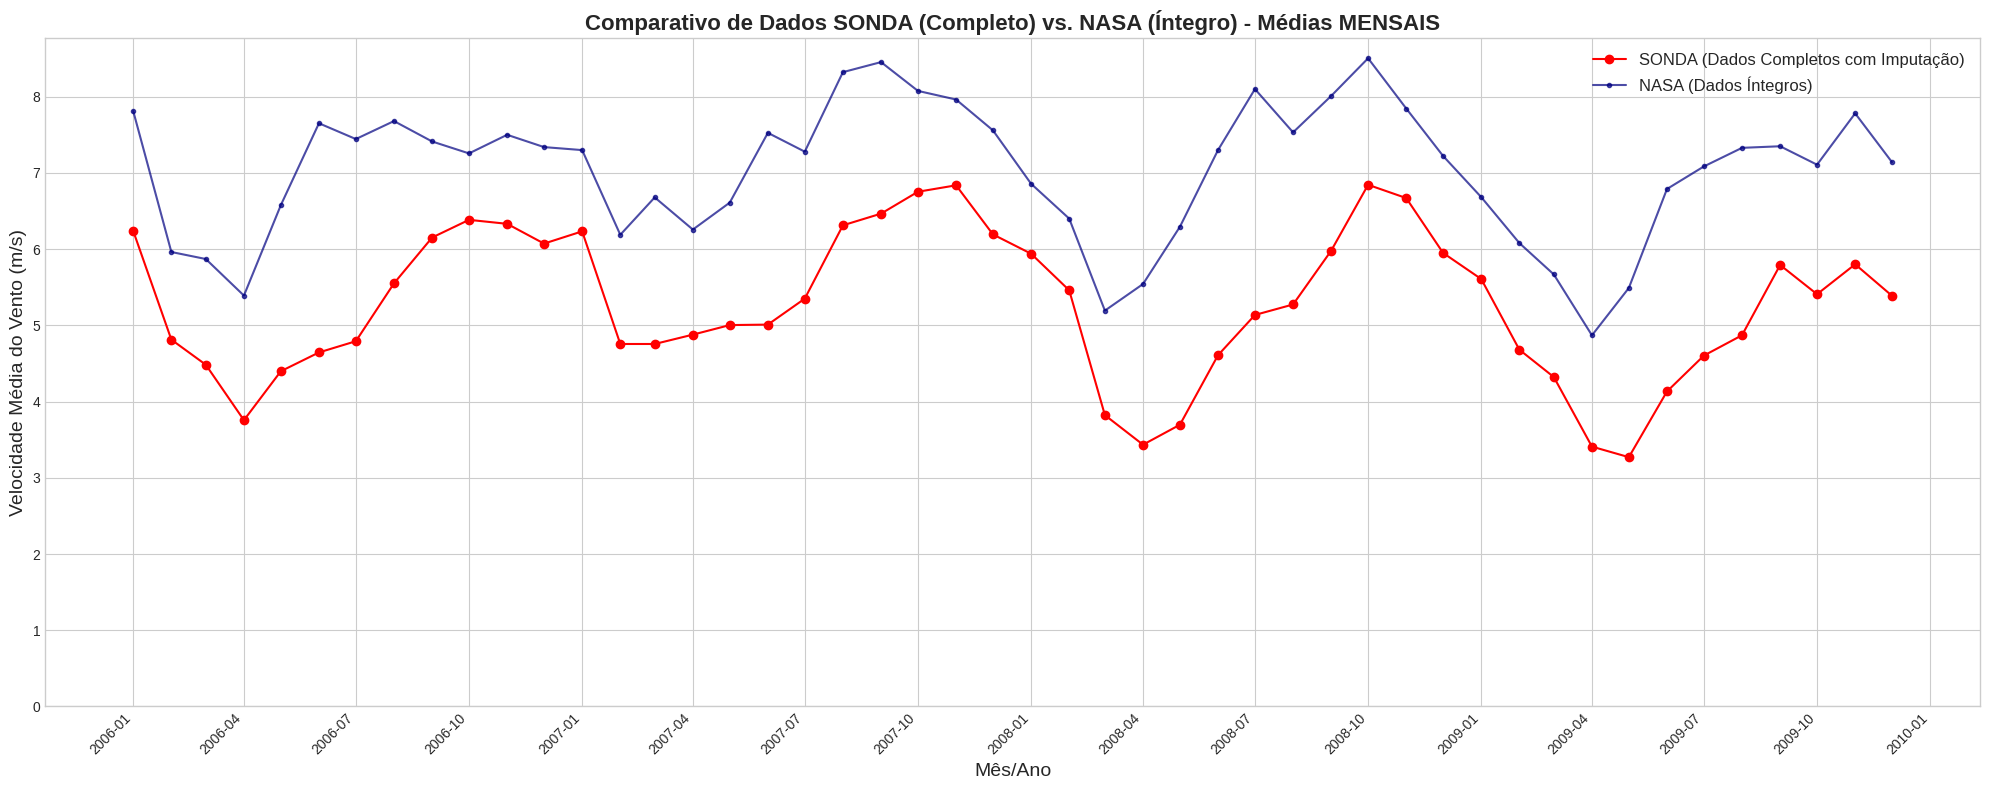

--- FIM DA GERAÇÃO DO GRÁFICO ---


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os

# --- Etapa: Gráfico de Séries Temporais do Dataset Final ---
print('=' * 80)
print("--- Gerando o Gráfico de Médias Mensais do Dataset WSCariri-DE ---")
print('=' * 80)

# Caminho para o arquivo final
path_wscariri_de = '/content/drive/MyDrive/projeto_wscariri/WSCariri-DE.csv'

try:
    # Carregar o dataset final e completo
    print(f"Carregando o arquivo: '{os.path.basename(path_wscariri_de)}'...")
    WSCariri_DE = pd.read_csv(path_wscariri_de, sep=";", index_col=0, parse_dates=True)
    WSCariri_DE.index.name = 'datetm'
    print("Dataset WSCariri-DE carregado com sucesso.")

    # 1. Reamostrar os dados para a média mensal
    # 'MS' significa 'Month Start'
    df_mensal_final = WSCariri_DE.resample('MS').mean()

    print("\nMédias mensais calculadas. Preparando para plotar o gráfico...")

    # 2. Gerar o gráfico de linhas
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(20, 8))

    # Plotar os dados da SONDA (agora completos)
    ax.plot(df_mensal_final.index, df_mensal_final['SONDAWS50'], marker='o', linestyle='-', color='red', label='SONDA (Dados Completos com Imputação)')

    # Plotar os dados da NASA
    ax.plot(df_mensal_final.index, df_mensal_final['NASAWS50'], marker='.', linestyle='-', color='navy', alpha=0.7, label='NASA (Dados Íntegros)')

    # --- Formatação do Gráfico ---
    ax.set_title('Comparativo de Dados SONDA (Completo) vs. NASA (Íntegro) - Médias MENSAIS', fontsize=16, weight='bold')
    ax.set_ylabel('Velocidade Média do Vento (m/s)', fontsize=14)
    ax.set_xlabel('Mês/Ano', fontsize=14)
    ax.legend(fontsize=12)

    # Formatar o eixo X para mostrar o ano e o mês de forma legível
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45, ha='right')

    ax.set_ylim(bottom=0)

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"\nERRO FATAL: O arquivo '{path_wscariri_de}' não foi encontrado.")
except Exception as e:
    print(f"\nERRO INESPERADO: {e}")

print('=' * 80)
print("--- FIM DA GERAÇÃO DO GRÁFICO ---")
print('=' * 80)